In [411]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.set(style="darkgrid")
style.use('seaborn-bright')

# drop simple_journal after converting to is_fraud
# Use CVC responsecode unknown as variable? False = CVCR_False, True = CVCR_True, unknown = CVCR_Unknown? convert to oneh?
# use functions for assessment

### Preprocessing 
We pre-process the dataset to prepare for visualization

- 1 Remove Refused transactions.
- 2 Empty cvc codes are converted to False values.
- 3 Add amount_converted column with GBP amount.
- 4 If issuercountrycode or shoppercountrycode is NaN fill it with the other.
- 5 Map cvc response codes from 0-6 to 0-3 using: 0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3.
- 6 Add boolean is_fraud column

In order to skip all preprocessing functions we can import the processed data from preprocess.csv

In [412]:
df = pd.read_csv('preprocess.csv')
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)

df_orig = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df_orig.bookingdate = pd.to_datetime(df.bookingdate)
df_orig.creationdate = pd.to_datetime(df.creationdate)
df_orig['is_fraud'] = df_orig['simple_journal'].apply(lambda x: x=='Chargeback')

If you want to process the file from the originally supplied file use the following code.

Read out the data from the data_for_student_case.csv and start preprocessing.

In [ ]:
df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))

# Convert dates to actual datetime format
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)

# Remove the refused transactions
df = df[df['simple_journal'] != 'Refused']

# Fill cardverificationcodesupplied NaN values with False
df.cardverificationcodesupplied.fillna(value=False, inplace=True)

def convert_currency(row):
    """
    Function for converting the amount to GBP
    """
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency])

def fix_countrycodes(row):
    """
    Function that fills in issuercountrycode or shoppercountrycode in the other if one of both is missing
    """
    if pd.isnull(row.issuercountrycode):
        row.issuercountrycode = row.shoppercountrycode
    elif pd.isnull(row.shoppercountrycode):
        row.shoppercountrycode = row.issuercountrycode
    return row
    
def changerows(row):
    """
    Function that takes in the rows and performs operations on it
    """
    if row.txid % 50000 == 0:
        print(row)
        
    # Now we add a column to all the data containing the transacted amount in GBP. 
    row['amount_convert'] = convert_currency(row)
    
    # if countrycodes are NaN use the code of the issuer/shoppercountry 
    row = fix_countrycodes(row)
    
    # map cvc response code to 0,1,2,3
    map_cvc = {0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3}
    
    row['cvcresponsecode'] = map_cvc[row['cvcresponsecode']]
    # Add is_fraud column for ease of use
    row['is_fraud'] = row['simple_journal'] == 'Chargeback'
    return row

# Perform the changerows function on all rows
df = df.apply(changerows, axis=1)
df.drop(['simple_journal', 'amount'], axis=1, inplace=True)

# Should be no more missing values
print(f'Total missing values: {df.isnull().values.sum()}\n')

df.head()
# Write to csv
# df.to_csv('preprocess.csv')

txid                                         250000
bookingdate                     2015-07-29 00:21:38
issuercountrycode                                GB
txvariantcode                             visadebit
bin                                          476367
amount                                        16000
currencycode                                    GBP
shoppercountrycode                               GB
shopperinteraction                        Ecommerce
simple_journal                              Settled
cardverificationcodesupplied                   True
cvcresponsecode                                   1
creationdate                    2015-07-26 21:03:45
accountcode                               UKAccount
mail_id                                 email107801
ip_id                                      ip296877
card_id                                  card153407
Name: 98638, dtype: object
txid                                         300000
bookingdate                     2015-

In [315]:
df.columns
#  Write to csv
# df.to_csv('preprocess.csv')

Index(['Unnamed: 0', 'txid', 'bookingdate', 'issuercountrycode',
       'txvariantcode', 'bin', 'currencycode', 'shoppercountrycode',
       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id',
       'amount_convert', 'is_fraud'],
      dtype='object')

Using the preprocessed data, the categorical variables are converted into one hot encoding. Per categorical variable we look at the implementation of hash encoding and if this improves performance. Only for the issuercountrycode and the shoppercountrycode using a has encoding improved the amount of columns used. For both categories a hash of size 5 was sufficient to keep all information. 

Columns in dataframe without processing: 17.
Columns in dataframe with preprocessing: 270.

In [336]:
# convert columns with categorical value to one hot encoded using a hash function
def cat_to_oneh(dataframe, column, hashsize):
    """
    Function for changing a column with categorical variables into multiple one hot encoded columns using hashes
    """
    df1 = df[column].copy()
    print(len(df1))
    df1 = df1.apply(lambda x: str(hash(x))[1:hashsize])
    df1 = pd.DataFrame(df1.str.split('').tolist())
    df1 = df1.drop([0, hashsize], axis=1)
    df1 = pd.get_dummies(df1)
    df1.columns = [column + '_' + x for x in df1.columns]
    df1.reset_index(inplace=True, drop=True)
    return df1

cat_cols = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode',
                        'shopperinteraction', 'accountcode', 'cvcresponsecode']
col_amounts = [1,0,0,1,0,0,0]
df.reset_index(inplace=True, drop=True)
index = 0
for col in cat_cols:
    if col_amounts[index]:
        df = pd.concat([df, cat_to_oneh(df, col, 6)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    index += 1
    df.drop(col, axis=1, inplace=True)
df.rename(columns={0:'cvcresp0', 1:'cvcresp1', 2:'cvcresp2', 3:'cvcresp3'}, inplace=True)  
# df.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)


237036
237036


In [317]:
for col in df.columns:
    print(col)

Unnamed: 0
txid
bookingdate
bin
cardverificationcodesupplied
creationdate
mail_id
ip_id
card_id
amount_convert
is_fraud
issuercountrycode_1_0
issuercountrycode_1_1
issuercountrycode_1_2
issuercountrycode_1_3
issuercountrycode_1_4
issuercountrycode_1_5
issuercountrycode_1_6
issuercountrycode_1_7
issuercountrycode_1_8
issuercountrycode_1_9
issuercountrycode_2_0
issuercountrycode_2_1
issuercountrycode_2_2
issuercountrycode_2_3
issuercountrycode_2_4
issuercountrycode_2_5
issuercountrycode_2_6
issuercountrycode_2_7
issuercountrycode_2_8
issuercountrycode_2_9
issuercountrycode_3_0
issuercountrycode_3_1
issuercountrycode_3_2
issuercountrycode_3_3
issuercountrycode_3_4
issuercountrycode_3_5
issuercountrycode_3_6
issuercountrycode_3_7
issuercountrycode_3_8
issuercountrycode_3_9
issuercountrycode_4_0
issuercountrycode_4_1
issuercountrycode_4_2
issuercountrycode_4_3
issuercountrycode_4_4
issuercountrycode_4_5
issuercountrycode_4_6
issuercountrycode_4_7
issuercountrycode_4_8
issuercountrycode_4_9


In [318]:

df_export.to_csv('processed_data.csv')

NameError: name 'df_export' is not defined

# Visualization
Using the preprocessed data visualization is started. The final graphs used are:
- 1: Fraud vs Amounts.
- 2: 

/usr/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


mean: 
#is_fraud
False     6765.743353
True     13068.417391
Name: amount_convert, dtype: float64

median: 
#is_fraud
False    5795
True     8110
Name: amount_convert, dtype: int64

std: 
#is_fraud
False     6007.507499
True     11591.806924
Name: amount_convert, dtype: float64

max amount: 
#is_fraud
False    298900
True      67454
Name: amount_convert, dtype: int64



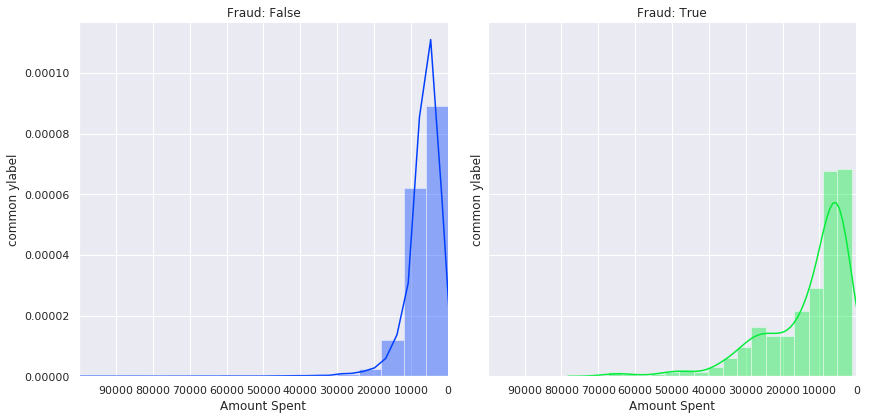

In [319]:
## Visualize fraud vs amounts
g = sns.FacetGrid(df, col="is_fraud", size=6, hue='is_fraud', xlim=100000)
g.map(sns.distplot,"amount_convert", kde=True)
g.set(xticks=range(0,100000, 10000))
g.set_titles('Fraud: {col_name}')
g.set(xlabel='Amount Spent', ylabel='common ylabel')

print(f"mean: \n#{df.groupby(by=['is_fraud'])['amount_convert'].mean()}\n")
print(f"median: \n#{df.groupby(by=['is_fraud'])['amount_convert'].median()}\n")
print(f"std: \n#{df.groupby(by=['is_fraud'])['amount_convert'].std()}\n")
print(f"max amount: \n#{df.groupby(by=['is_fraud'])['amount_convert'].max()}\n")

Form the plots above we can see that the transacted amount for fraud transactions is higher on average than the non fraud ones, and also contain more outliers for the higher amounts.

Looking at the numerical values of the mean and deviation the transacted amounts we see confirmation that the mean amount of fraudulent transactions is much higher than non-fraudulent ones, mainly caused by large outliers.


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


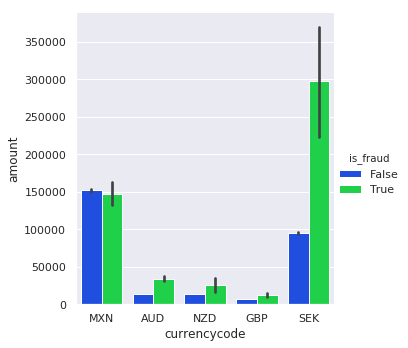

In [246]:
sns.factorplot(data=df_orig, kind='bar', x="currencycode", y="amount", hue="is_fraud")


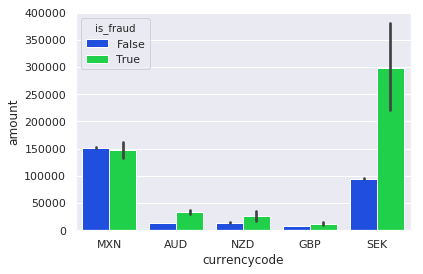

In [251]:
# Bar plot of fraud vs legit transations per currencycode
sns.barplot(data=df_orig, x="currencycode", y="amount", hue="is_fraud")

In [ ]:
# Amount of fraudulent tranactions per account code
# MexicoAccount has by far the most fraudulent transations, but the amounts are much lower per fraudulent transaction.
# SwedenAccount has the lowest number of fraudulent txs, but the amount of money involved is the highest
fraudulent = df[df["is_fraud"] == 1]
plt.figure()
fraudulent['accountcode'].value_counts().plot(kind='bar')
plt.figure()
sns.barplot(data=df, x="accountcode", y="amount_convert", hue="is_fraud")

In [ ]:
# same visualisation as above but with txvariantcode.
# Mccredit has the highest num of fraud tx but not the highest amount, although there are some with way less
# plt.figure()
fraudulent['txvariantcode'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.figure()
g = sns.barplot(data=df, x="txvariantcode", y="amount_convert", hue="is_fraud")
g.set_xticklabels(rotation=30)

In [ ]:
# Amount of fraud over time shows a very small decline in the amount of fraud committed over time.
fraudulent = df[df["is_fraud"] == 1]
len(fraudulent)

# attempt 1
# sns.lineplot(x="bookingdate", y="amount", data=fraudulent.sort_index(by='bookingdate'))

#attempt 2
# fraudulent.set_index("bookingdate").groupby(pd.Grouper(freq='M')).head()
# plt = sns.lineplot(x="creationdate", y="amount", data=gr)
# plt.xticks(rotation=70)

#attempt 3
plt.figure();
fraudulent.set_index("creationdate").plot(figsize=(15,10), y='amount')

/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


spent_in_issue_country  is_fraud
False                   False        10009
                        True            15
True                    False       226682
                        True           330
Name: is_fraud, dtype: int64


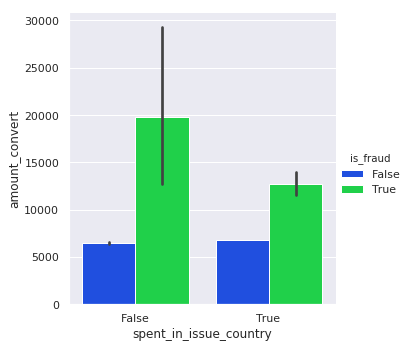

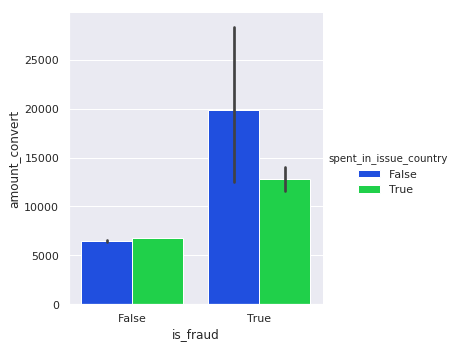

In [410]:
# Attempting to explore is theres a higher chance of fraud when issuercountrycode != shoppercountrycode

is_equal = df_orig[df_orig['issuercountrycode'] == df_orig['shoppercountrycode']]
not_equal = df_orig[df_orig['issuercountrycode'] != df_orig['shoppercountrycode']]

spent_in_issue_country = df_orig['issuercountrycode'] == df_orig['shoppercountrycode']
df['spent_in_issue_country'] = spent_in_issue_country

sns.factorplot(data=df, kind='bar', x="spent_in_issue_country", y="amount_convert", hue="is_fraud")
sns.factorplot(data=df, kind='bar', x="is_fraud", y="amount_convert", hue="spent_in_issue_country")

group = df.groupby(["spent_in_issue_country", "is_fraud"])["is_fraud"].count()
# group[0].plot.bar(title="spent_in_issue_country=False")
# group[1].plot.bar(title="spent_in_issue_country=True")

# group[0].plot.pie(subplots=True)
print(group)

In [398]:
df.value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

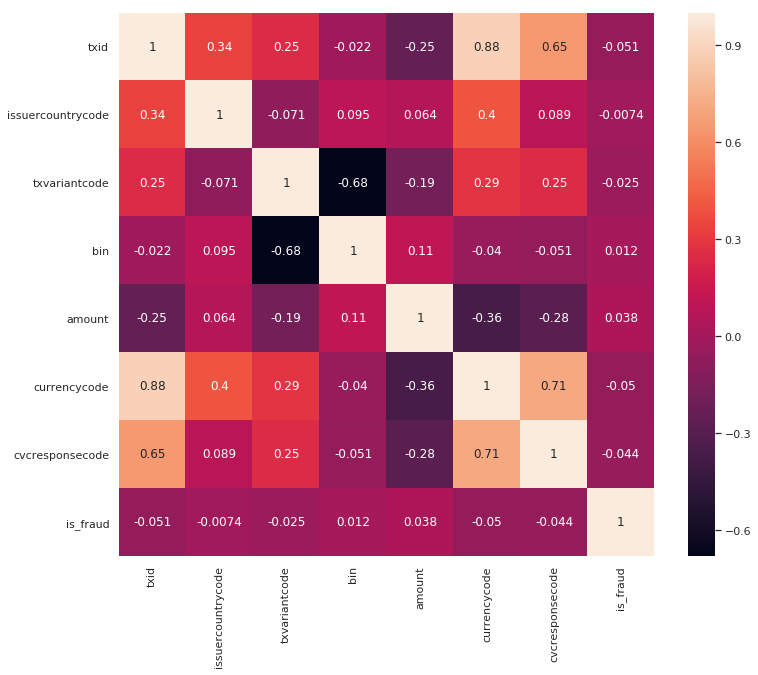

In [261]:
# Heatmap, only numerical data is taken into account, 
# may need to encode some data to add exra columns <- may cause wrong correlations
# is_fraud appears to have extremely low correlation with all other columns, 
# especially the column of interest 'is_fraud'

def create_list_mapping(somelist):
    # takes a list eg ["A", "B"] and maps it to a dict eq {"A": 0, "B": 1}
    return {x:somelist.tolist().index(x) for x in somelist}

issuercountrycode_map = create_list_mapping(df_orig['issuercountrycode'].unique())
txvariantcode_map = create_list_mapping(df_orig['txvariantcode'].unique())
currencycode_map = create_list_mapping(df_orig['currencycode'].unique())

df_remapped = df_orig.replace(issuercountrycode_map)
df_remapped = df_remapped.replace(txvariantcode_map)
df_remapped = df_remapped.replace(currencycode_map)

plt.figure(figsize=(12,10))
sns.heatmap(df_remapped.corr(), annot=True)

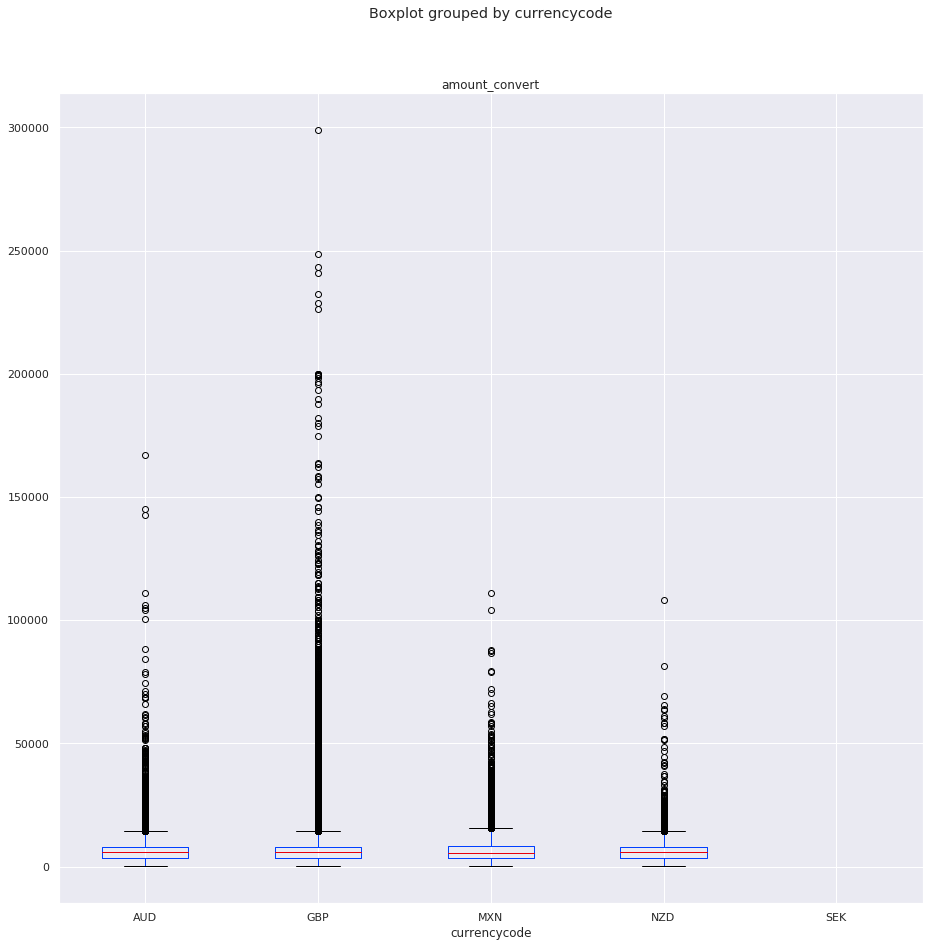

In [269]:
# df.boxplot('amount_convert', 'accountcode', figsize=(15,15))
df_orig['amount_convert'] = df['amount_convert']
df_orig.boxplot('amount_convert', 'currencycode', figsize=(15,15))

txid  bookingdate  issuercountrycode  \
hascardverification is_fraud                                           
False               False      12983        12983              12983   
                    True           2            2                  2   
True                False     223708       223708             223343   
                    True         343          343                340   

                              txvariantcode     bin  amount  currencycode  \
hascardverification is_fraud                                                
False               False             12983   12983   12983         12983   
                    True                  2       2       2             2   
True                False            223708  223669  223708        223708   
                    True                343     343     343           343   

                              shoppercountrycode  shopperinteraction  \
hascardverification is_fraud                                           
False               False                  12969               12983   
                    True                       2                   2   
True                False                 223390              223708   
                    True                     343                 343   

                              simple_journal  cardverificationcodesupplied  \
hascardverification is_fraud                                                 
False               False              12983                             0   
                    True                   2                             0   
True                False             223708                        223708   
                    True                 343                           343   

                              cvcresponsecode  creationdate  accountcode  \
hascardverification is_fraud                                               
False               False               12983         12983        12983   
                    True                    2             2            2   
True                False              223708        223708       223708   
                    True                  343           343          343   

                              mail_id   ip_id  card_id  is_fraud  \
hascardverification is_fraud                                       
False               False       12983   12983    12983     12983   
                    True            2       2        2         2   
True                False      223708  223708   223708    223708   
                    True          343     343      343       343   

                              amount_convert  
hascardverification is_fraud                  
False               False              12983  
                    True                   2  
True                False             223708  
                    True                 343

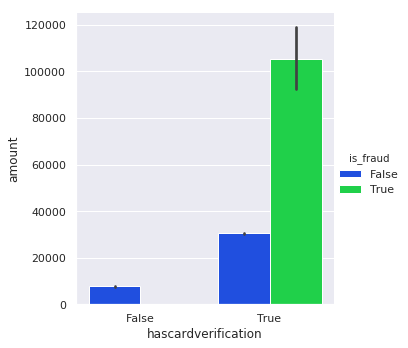

In [275]:
# No card verification code supplied has no cases of fraud,
df_orig['hascardverification'] = df_orig['cardverificationcodesupplied'].apply(lambda x: isinstance(x, int))
df['hascardverification'] = df_orig['cardverificationcodesupplied'].apply(lambda x: isinstance(x, int))
sns.factorplot(data=df_orig, kind='bar', x="hascardverification", y="amount", hue='is_fraud')

df_orig.groupby([df_orig['hascardverification'], df['is_fraud']]).count()

## Imbalance Task
Process the data such that you can apply SMOTE to it. SMOTE is included in most analysis platforms, if not you can write the scripts for it yourself. Analyze the performance of at least three classifiers on the SMOTEd and UNSMOTEd data using ROC analysis. Provide the obtained ROC curves and explain which method performs best. Is using SMOTE a good idea? Why (not)

Classifiers:
- Random Forest
- Logistic Regression 
- Support Vector Machine

## Smote

In [354]:
# Applying smote
from imblearn.over_sampling import SMOTE

def apply_smote(data, fraud_rows):
    smt = SMOTE(random_state=0)
    X_train, y_train = smt.fit_sample(data, fraud_rows)
    return X_train, y_train 


## Spliting into test and training set

In [355]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

def split_data(x, y):
    values_to_predict = np.array(y)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        x, values_to_predict, test_size = 0.25, random_state = 42)
    
    return train_features, test_features, train_labels, test_labels

## Random Forest

In [372]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

def random_forrest(train_features, test_features, train_labels, test_labels):
    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 100, random_state = 10)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
#     errors = abs(predictions - test_labels)
    return predictions#, errors

# Metrics for assessing classifiers

In [357]:
from sklearn.metrics import confusion_matrix
def plot_roc_curve(fpr, tpr):  
    plt.figure(figsize=(12,8), dpi=300)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    return plt

def get_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'True Neg: {tn}, False pos: {fp}, False neg: {fn}, True pos: {tp}')
    return (tn, fp, fn, tp)

Get dataset ready for algorithms

In [358]:
df.columns

Index(['Unnamed: 0', 'txid', 'bookingdate', 'bin',
       'cardverificationcodesupplied', 'creationdate', 'mail_id', 'ip_id',
       'card_id', 'amount_convert',
       ...
       'Ecommerce', 'POS', 'APACAccount', 'MexicoAccount', 'SwedenAccount',
       'UKAccount', 'cvcresp0', 'cvcresp1', 'cvcresp2', 'cvcresp3'],
      dtype='object', length=140)

In [382]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

def split_and_smote(columns):
    fraud_rows = df['is_fraud']
    df_exp = df.drop(["bookingdate", "creationdate", 
                      "mail_id", 
                      "ip_id", 
                      "card_id",
                      "is_fraud",
                      "txid"], axis = 1).copy()

    # Selecting a bunch of columns we want to use for classification
    # cols = [x for i, x in enumerate(df_exp.columns) if "issuercountry" in x]
    # cols.extend([x for i, x in enumerate(df_exp.columns) if "amount" in x])
    # cols.extend([x for i, x in enumerate(df_exp.columns) if "spent_in" in x])
    # cols.extend([x for i, x in enumerate(df_exp.columns) if "cardverificationcodesupplied" in x])
    # cols.extend([x for i, x in enumerate(df_exp.columns) if "cvcresp" in x])
    # cols.extend(['POS', 'APACAccount', 'MexicoAccount', 'SwedenAccount', 'UKAccount'])
    # cols = ['amount_convert']
    
    if len(columns) > 0:
        noncols = [x for i, x in enumerate(df_exp.columns) if x not in columns]
        df_exp = df_exp.drop(noncols, axis=1)

    # apply smote and splitting
    train_features, test_features, train_labels, test_labels = split_data(df_exp, fraud_rows)
    X_train, y_train = apply_smote(train_features, train_labels)
    return X_train, y_train, train_features, test_features, train_labels, test_labels


Apply algorithms

True Neg: 54490, False pos: 4679, False neg: 41, True pos: 49
AUC: 0.73


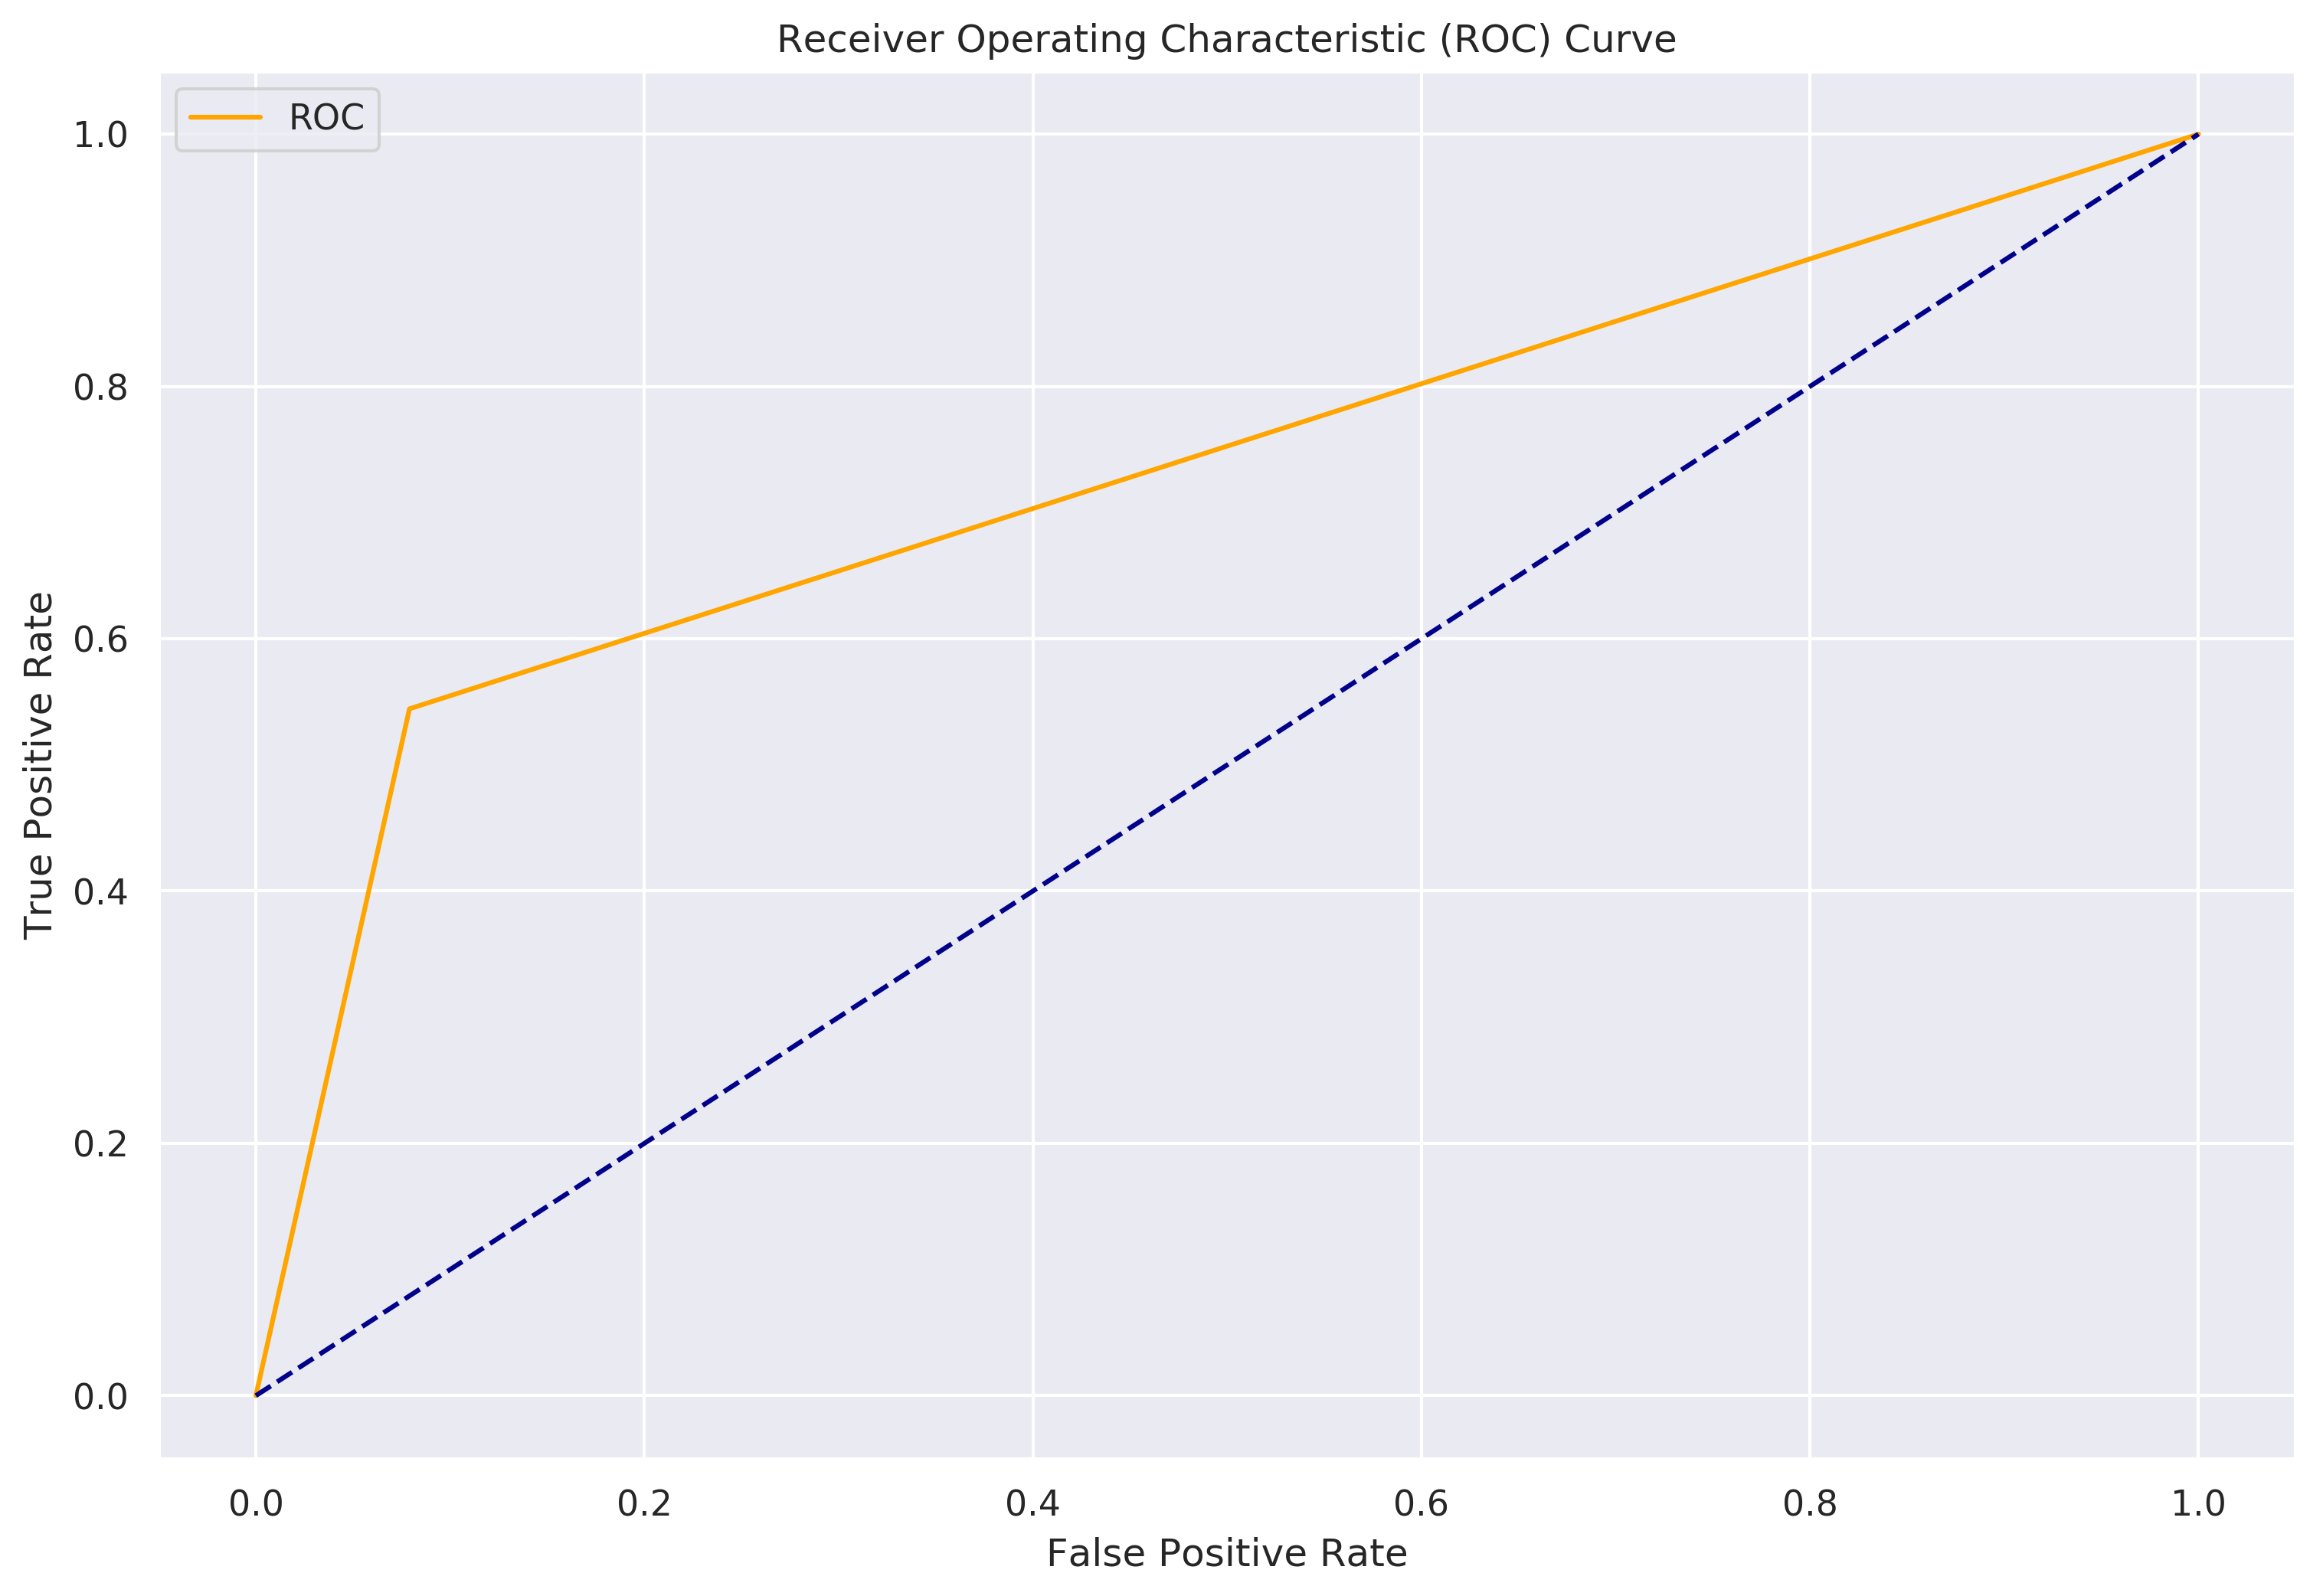

In [374]:
# Random Forrest predictor WITH SMOTE
from sklearn.metrics import confusion_matrix

X_train, y_train, train_features, test_features, train_labels, test_labels = split_and_smote(['amount_convert'])
predictions = random_forrest(X_train, test_features, y_train, test_labels)

pred = [round(x) for x in predictions]
get_metric(test_labels, predictions)
auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
plot_roc_curve(fpr, tpr).show()
    

True Neg: 59158, False pos: 11, False neg: 89, True pos: 1
AUC: 0.51


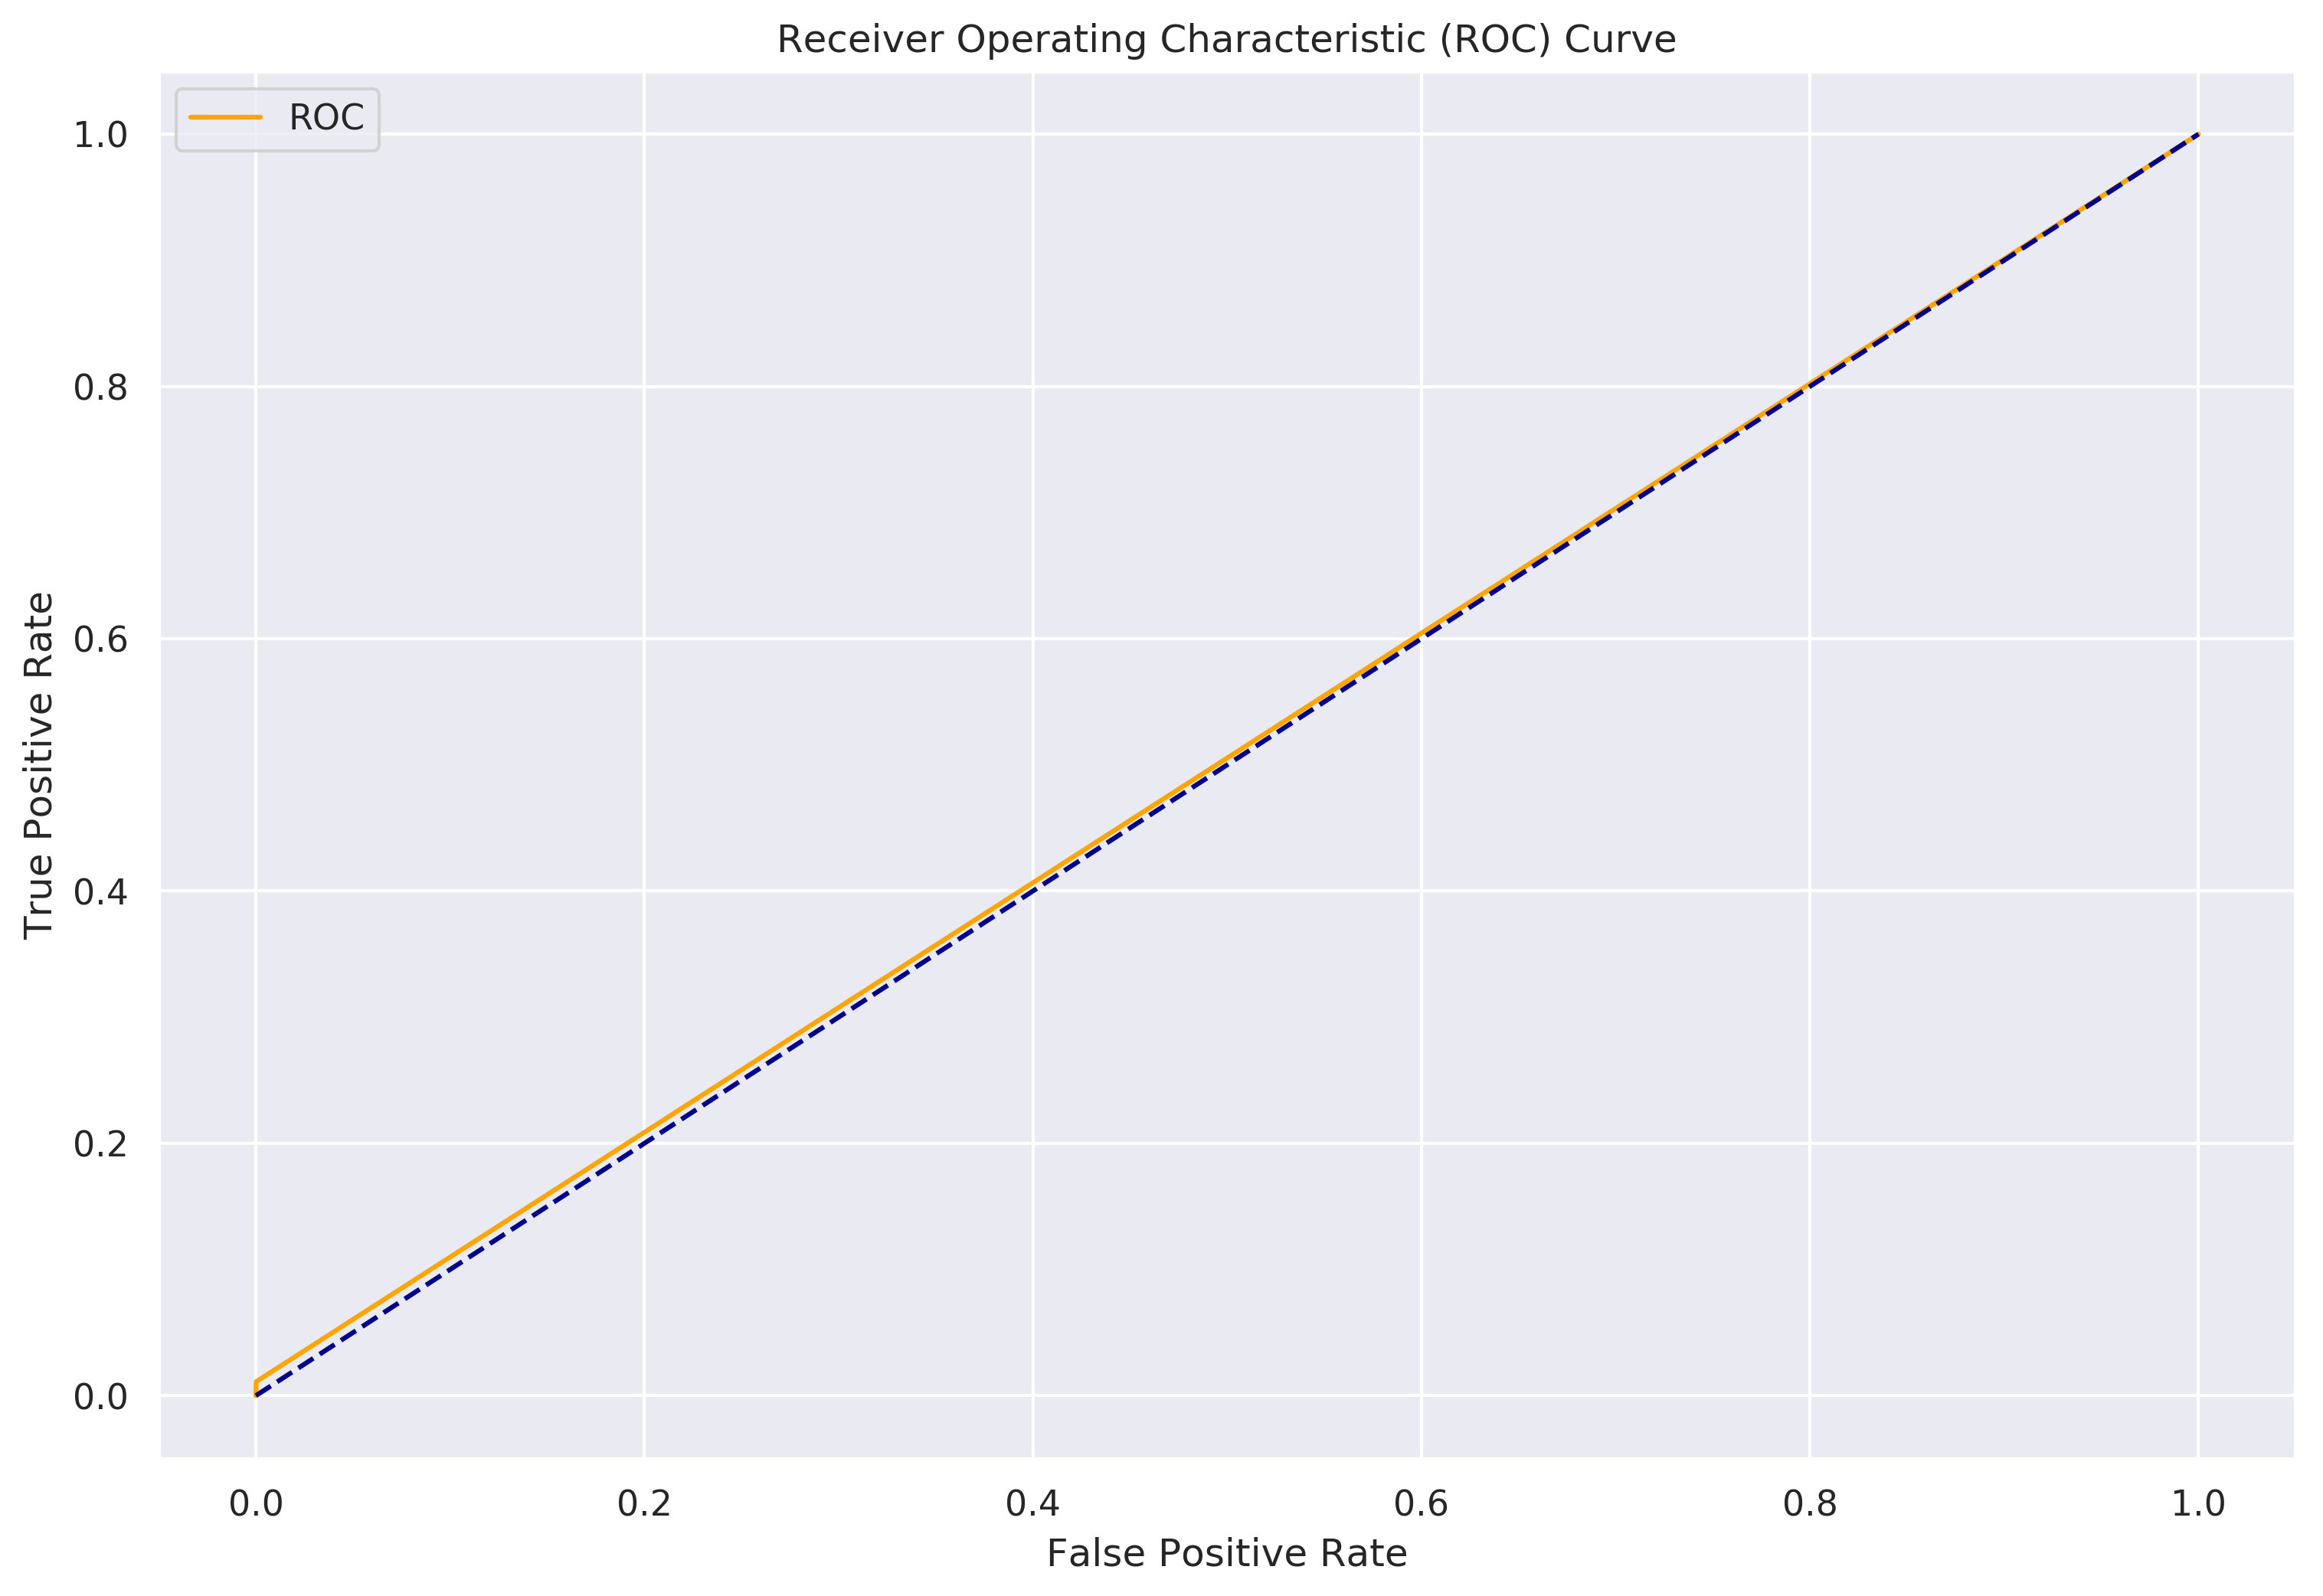

In [373]:
# Random Forrest predictor WITHOUT SMOTE

X_train, y_train, train_features, test_features, train_labels, test_labels = split_and_smote(
    ['amount_convert', 'spent_in_issuer_country'])
predictions = random_forrest(train_features, test_features, train_labels, test_labels)

pred = [round(x) for x in predictions]
get_metric(test_labels, predictions)
auc = roc_auc_score(test_labels, predictions)
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
plot_roc_curve(fpr, tpr).show()


## Neural nets

In [383]:

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

def perform_pca(variables):
    # 3 gave the best results
    return PCA(n_components=3).fit_transform(variables)

def neural_net(x_train, y_train, x_test, test_labels):
    # Perform PCA
    X_pca_train = perform_pca(x_train)
    X_pca_test = perform_pca(x_test)
    
    # Initialize MLP and fit
    mlp = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(15,), random_state=0)
    mlp.fit(X_pca_train, y_train)
    
    # Predict test set
    predictions = mlp.predict(X_pca_test)
    
    # Evaluate predictions
    get_metric(test_labels, predictions)
    auc = roc_auc_score(test_labels, predictions)  
    print('AUC: %.2f' % auc)  
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
    plot_roc_curve(fpr, tpr).show()
    

True Neg: 59169, False pos: 0, False neg: 90, True pos: 0
AUC: 0.50


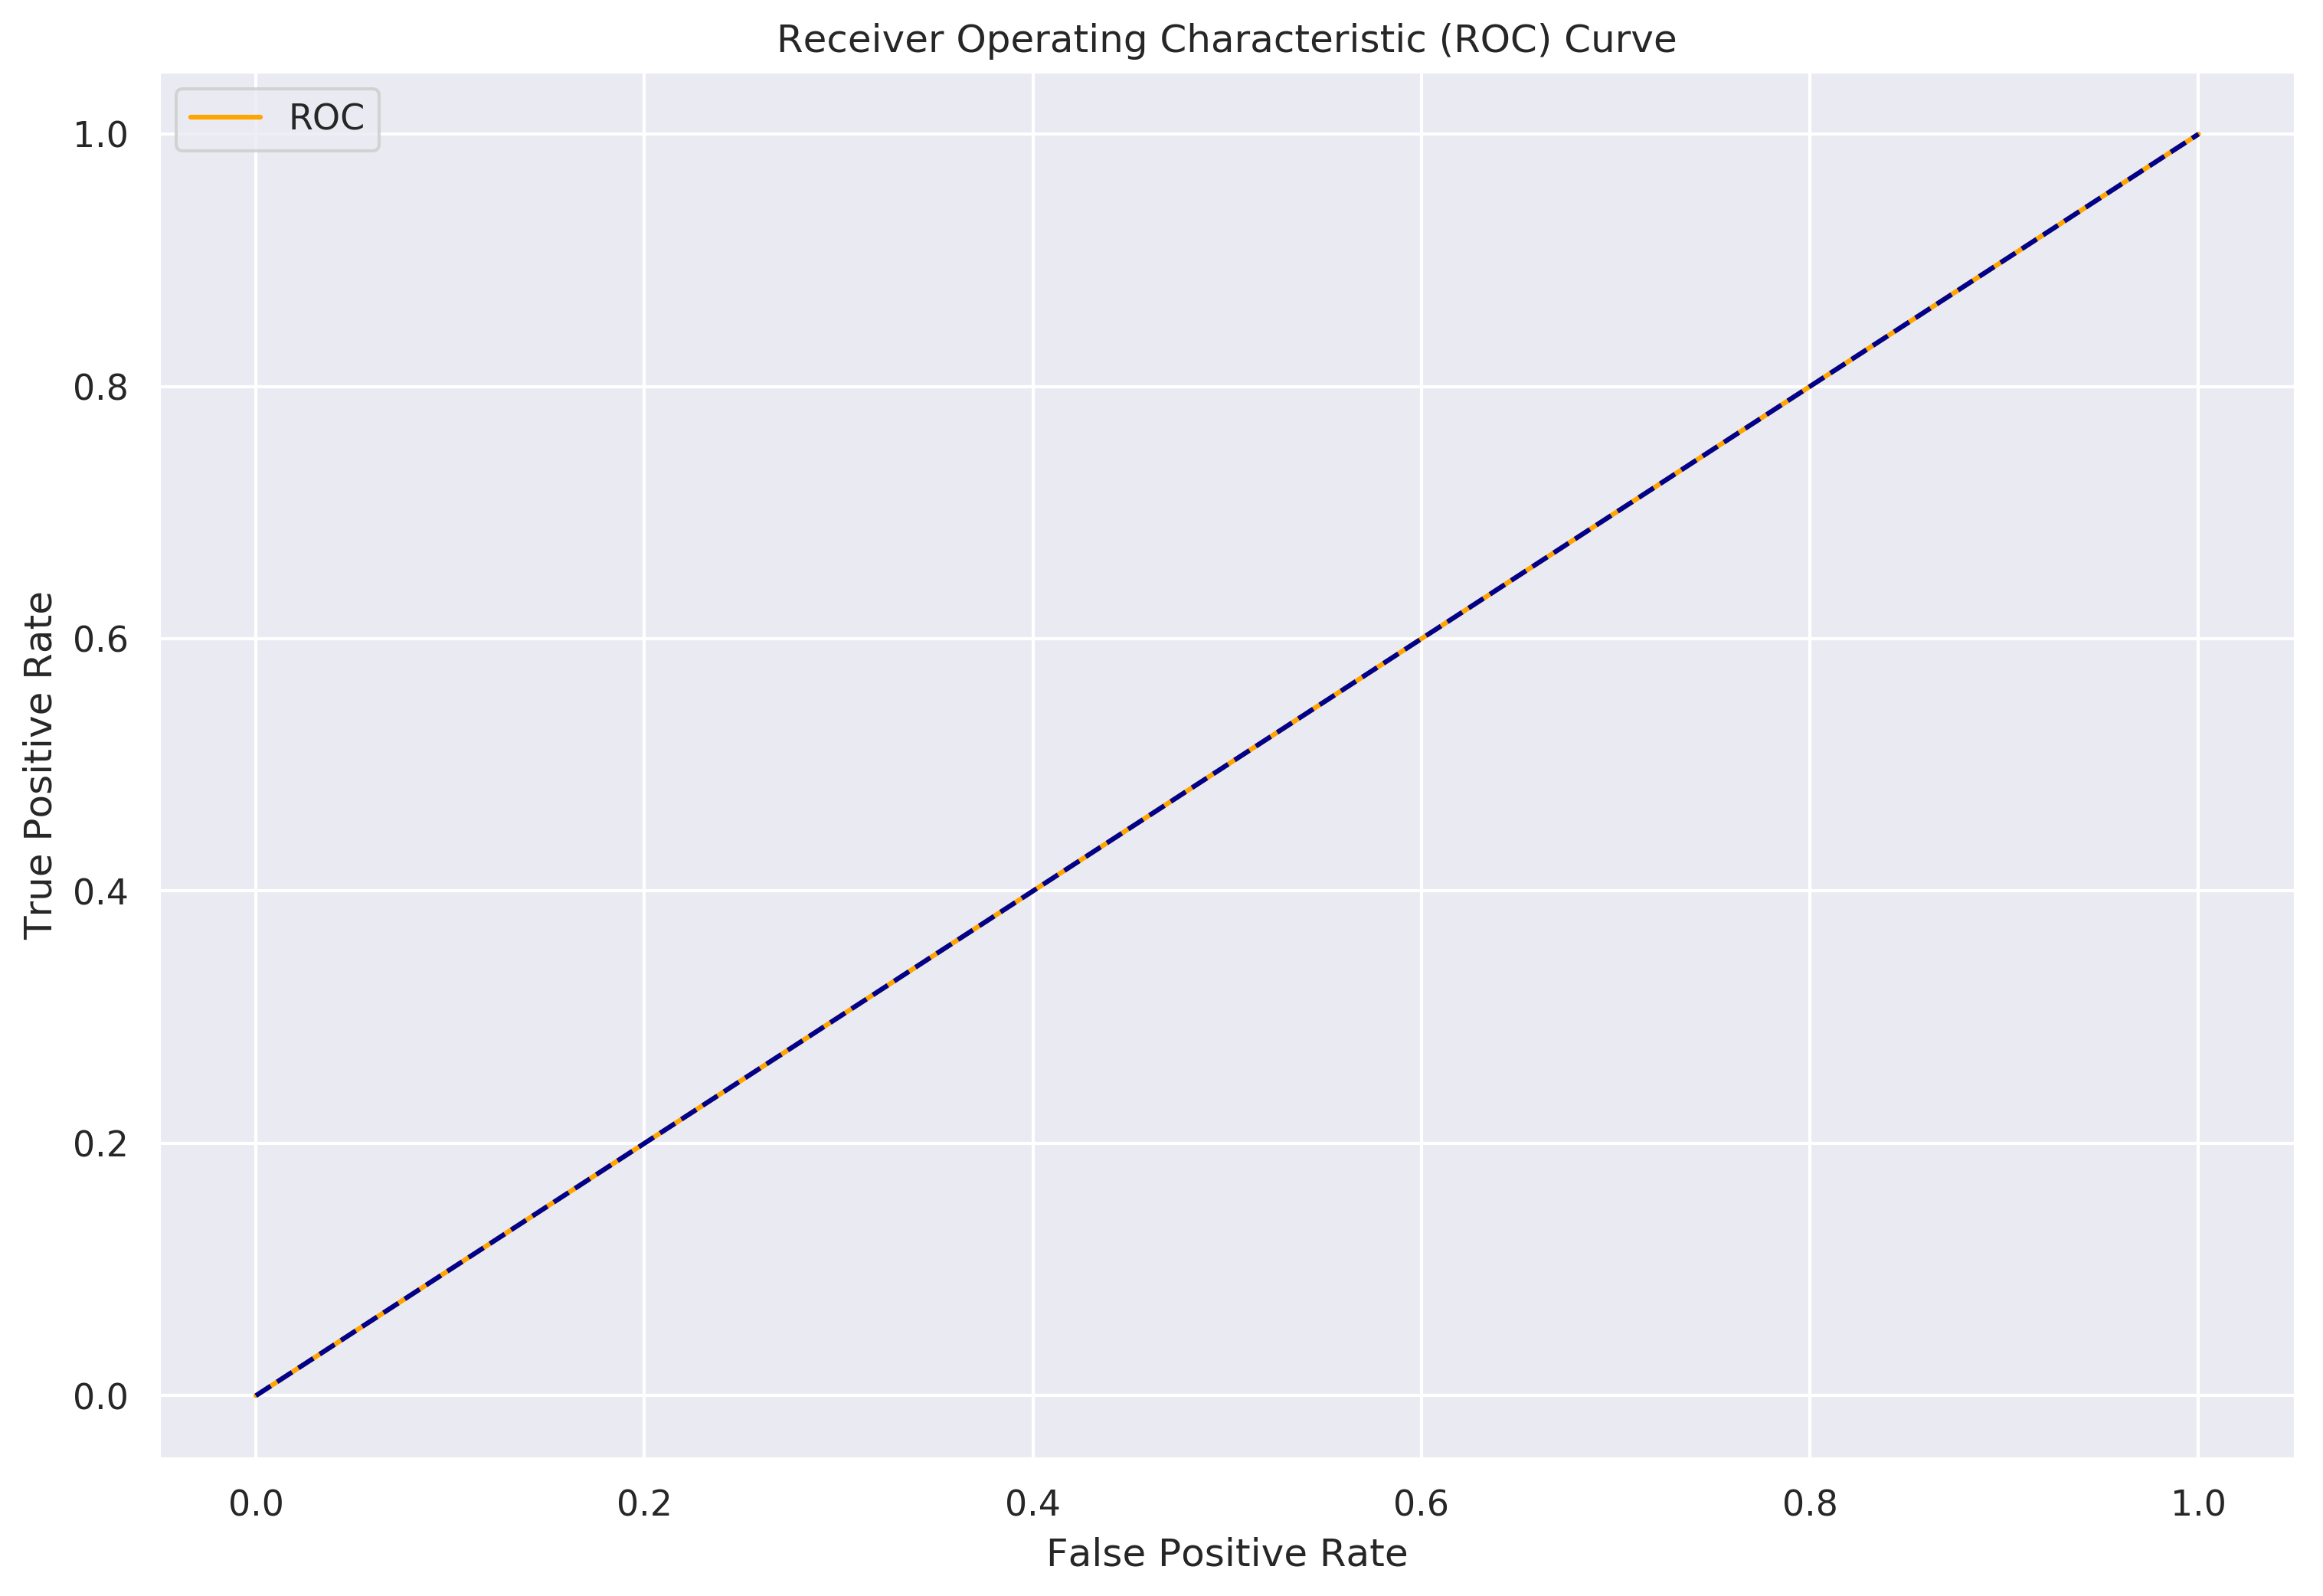

/usr/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


True Neg: 40931, False pos: 18238, False neg: 7, True pos: 83
AUC: 0.81


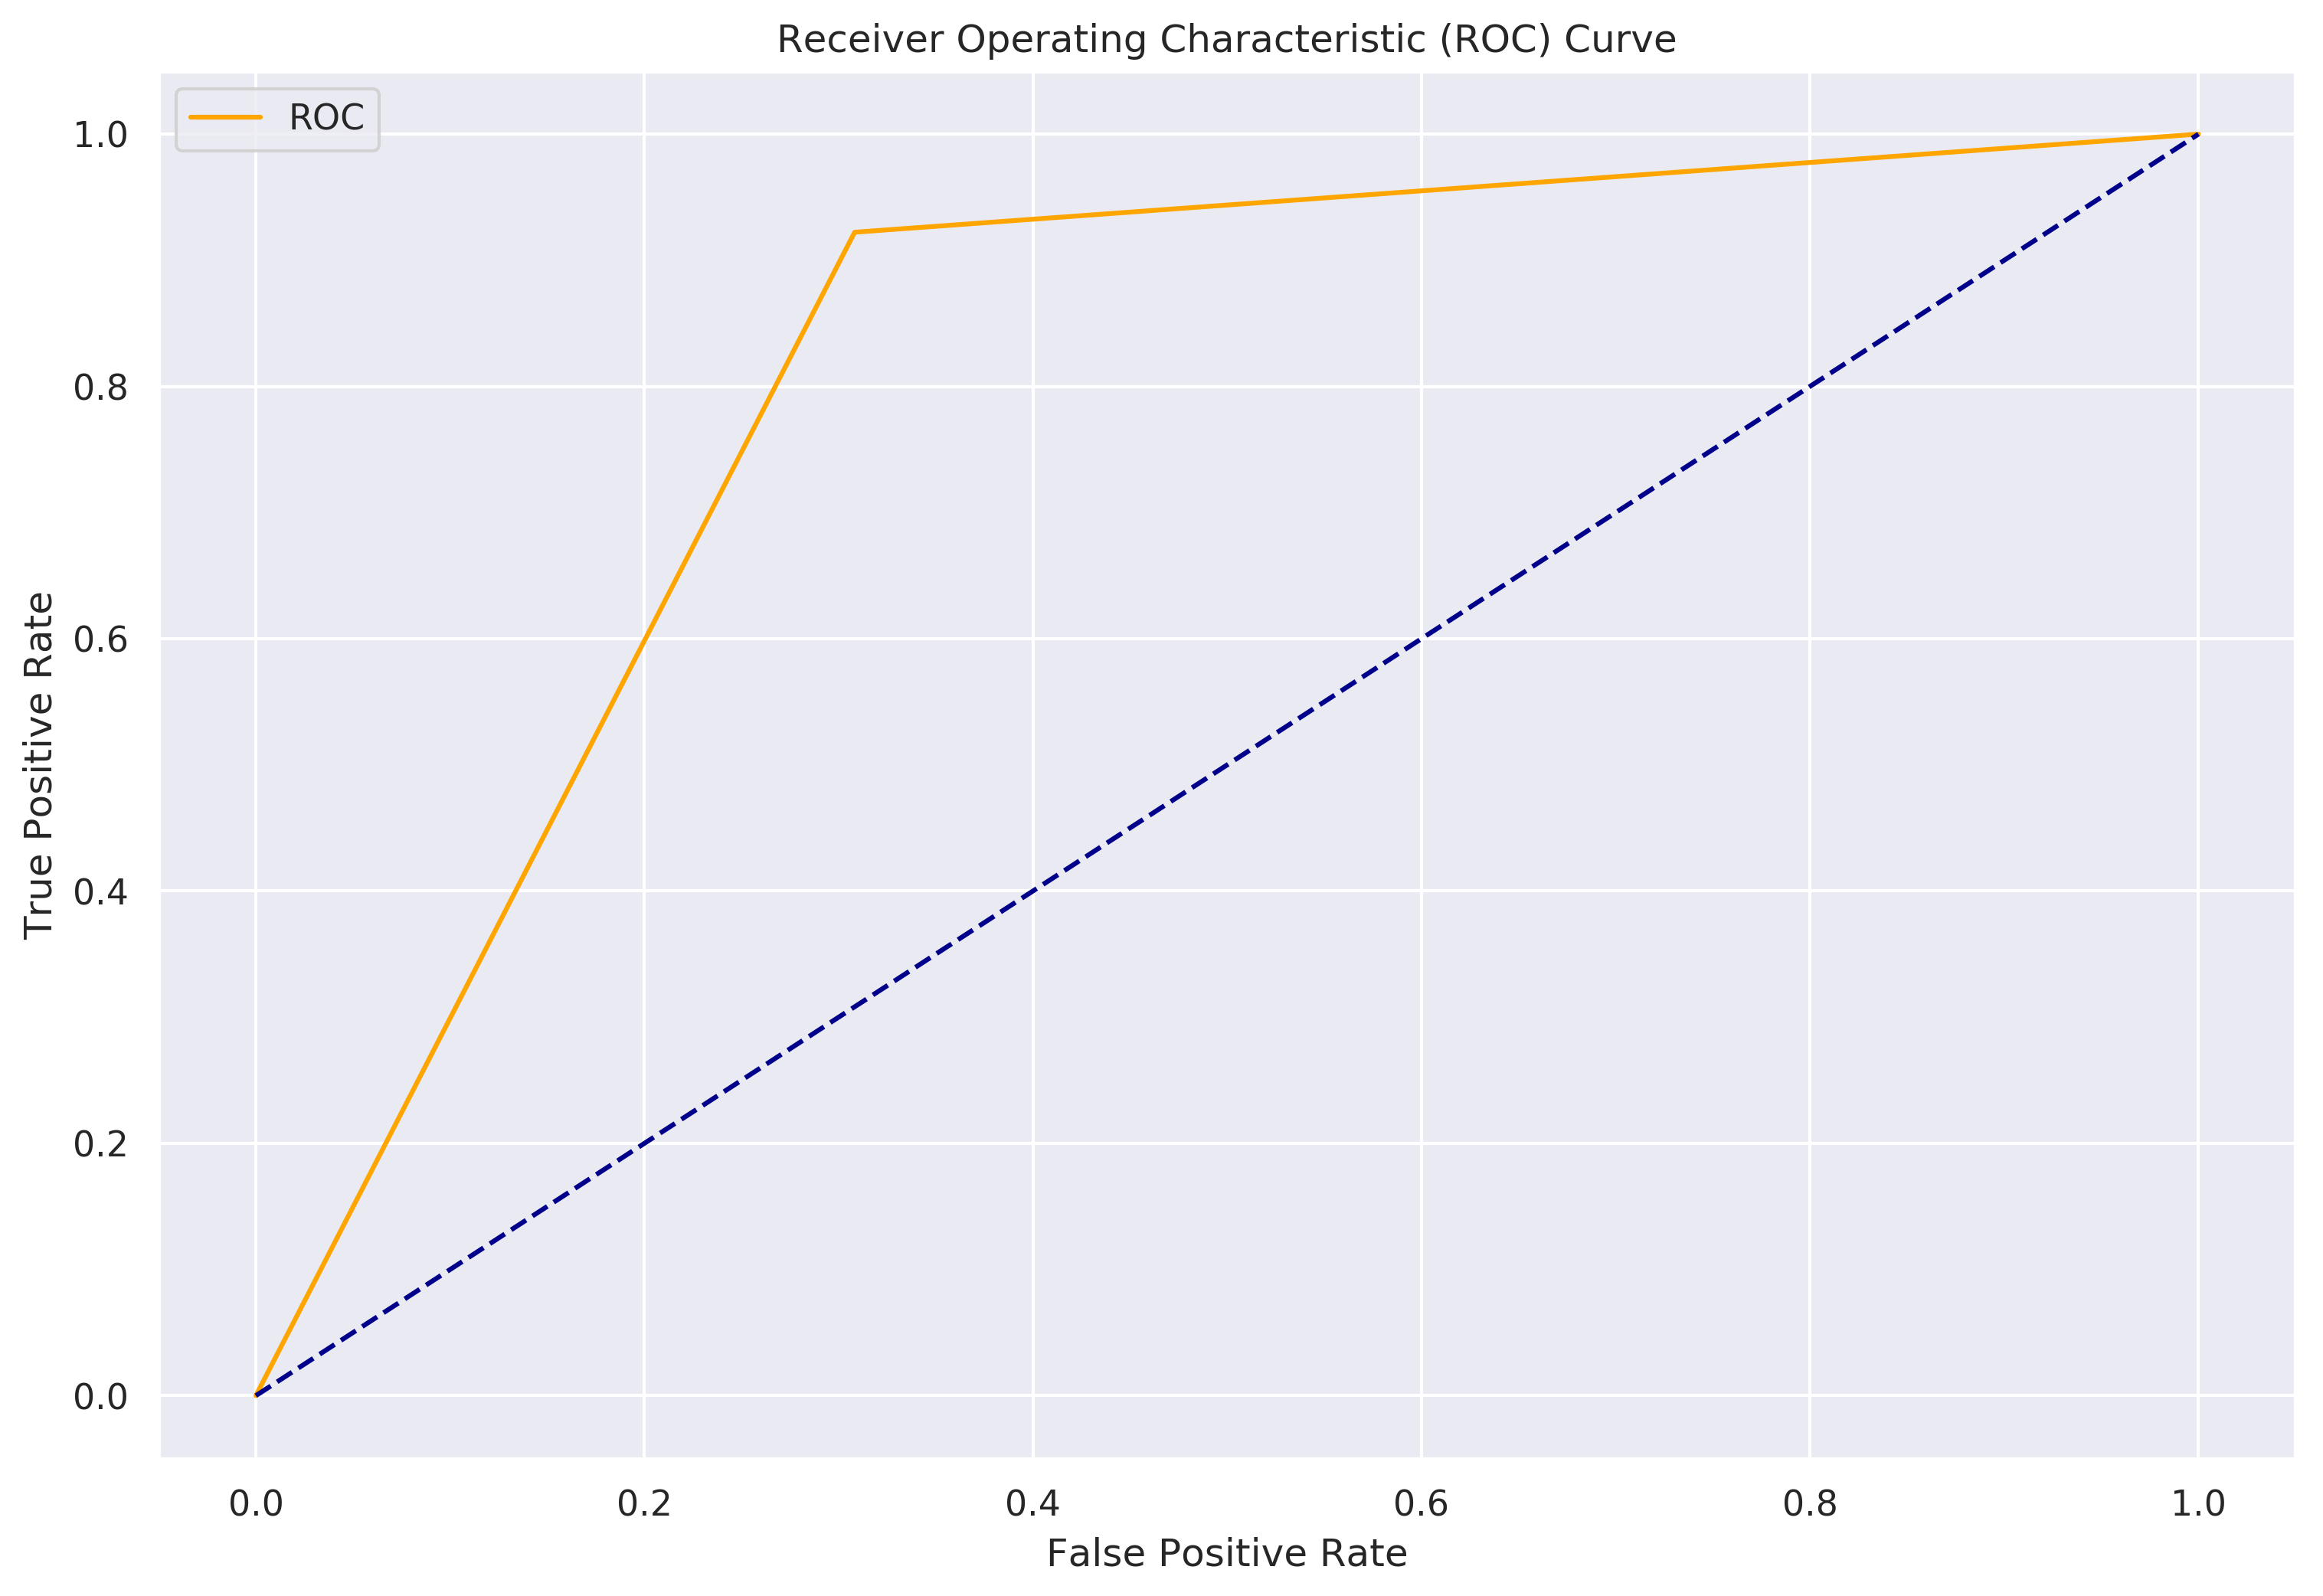

In [384]:

X_train, y_train, train_features, test_features, train_labels, test_labels = split_and_smote([])
# Neural Net without smote
neural_net(train_features, train_labels, test_features, test_labels)

# Neural Net with smote
neural_net(X_train, y_train, test_features, test_labels)

# Logistic Regression

[False  True False ... False False  True]
True Neg: 49095, False pos: 10074, False neg: 9, True pos: 81
AUC: 0.86


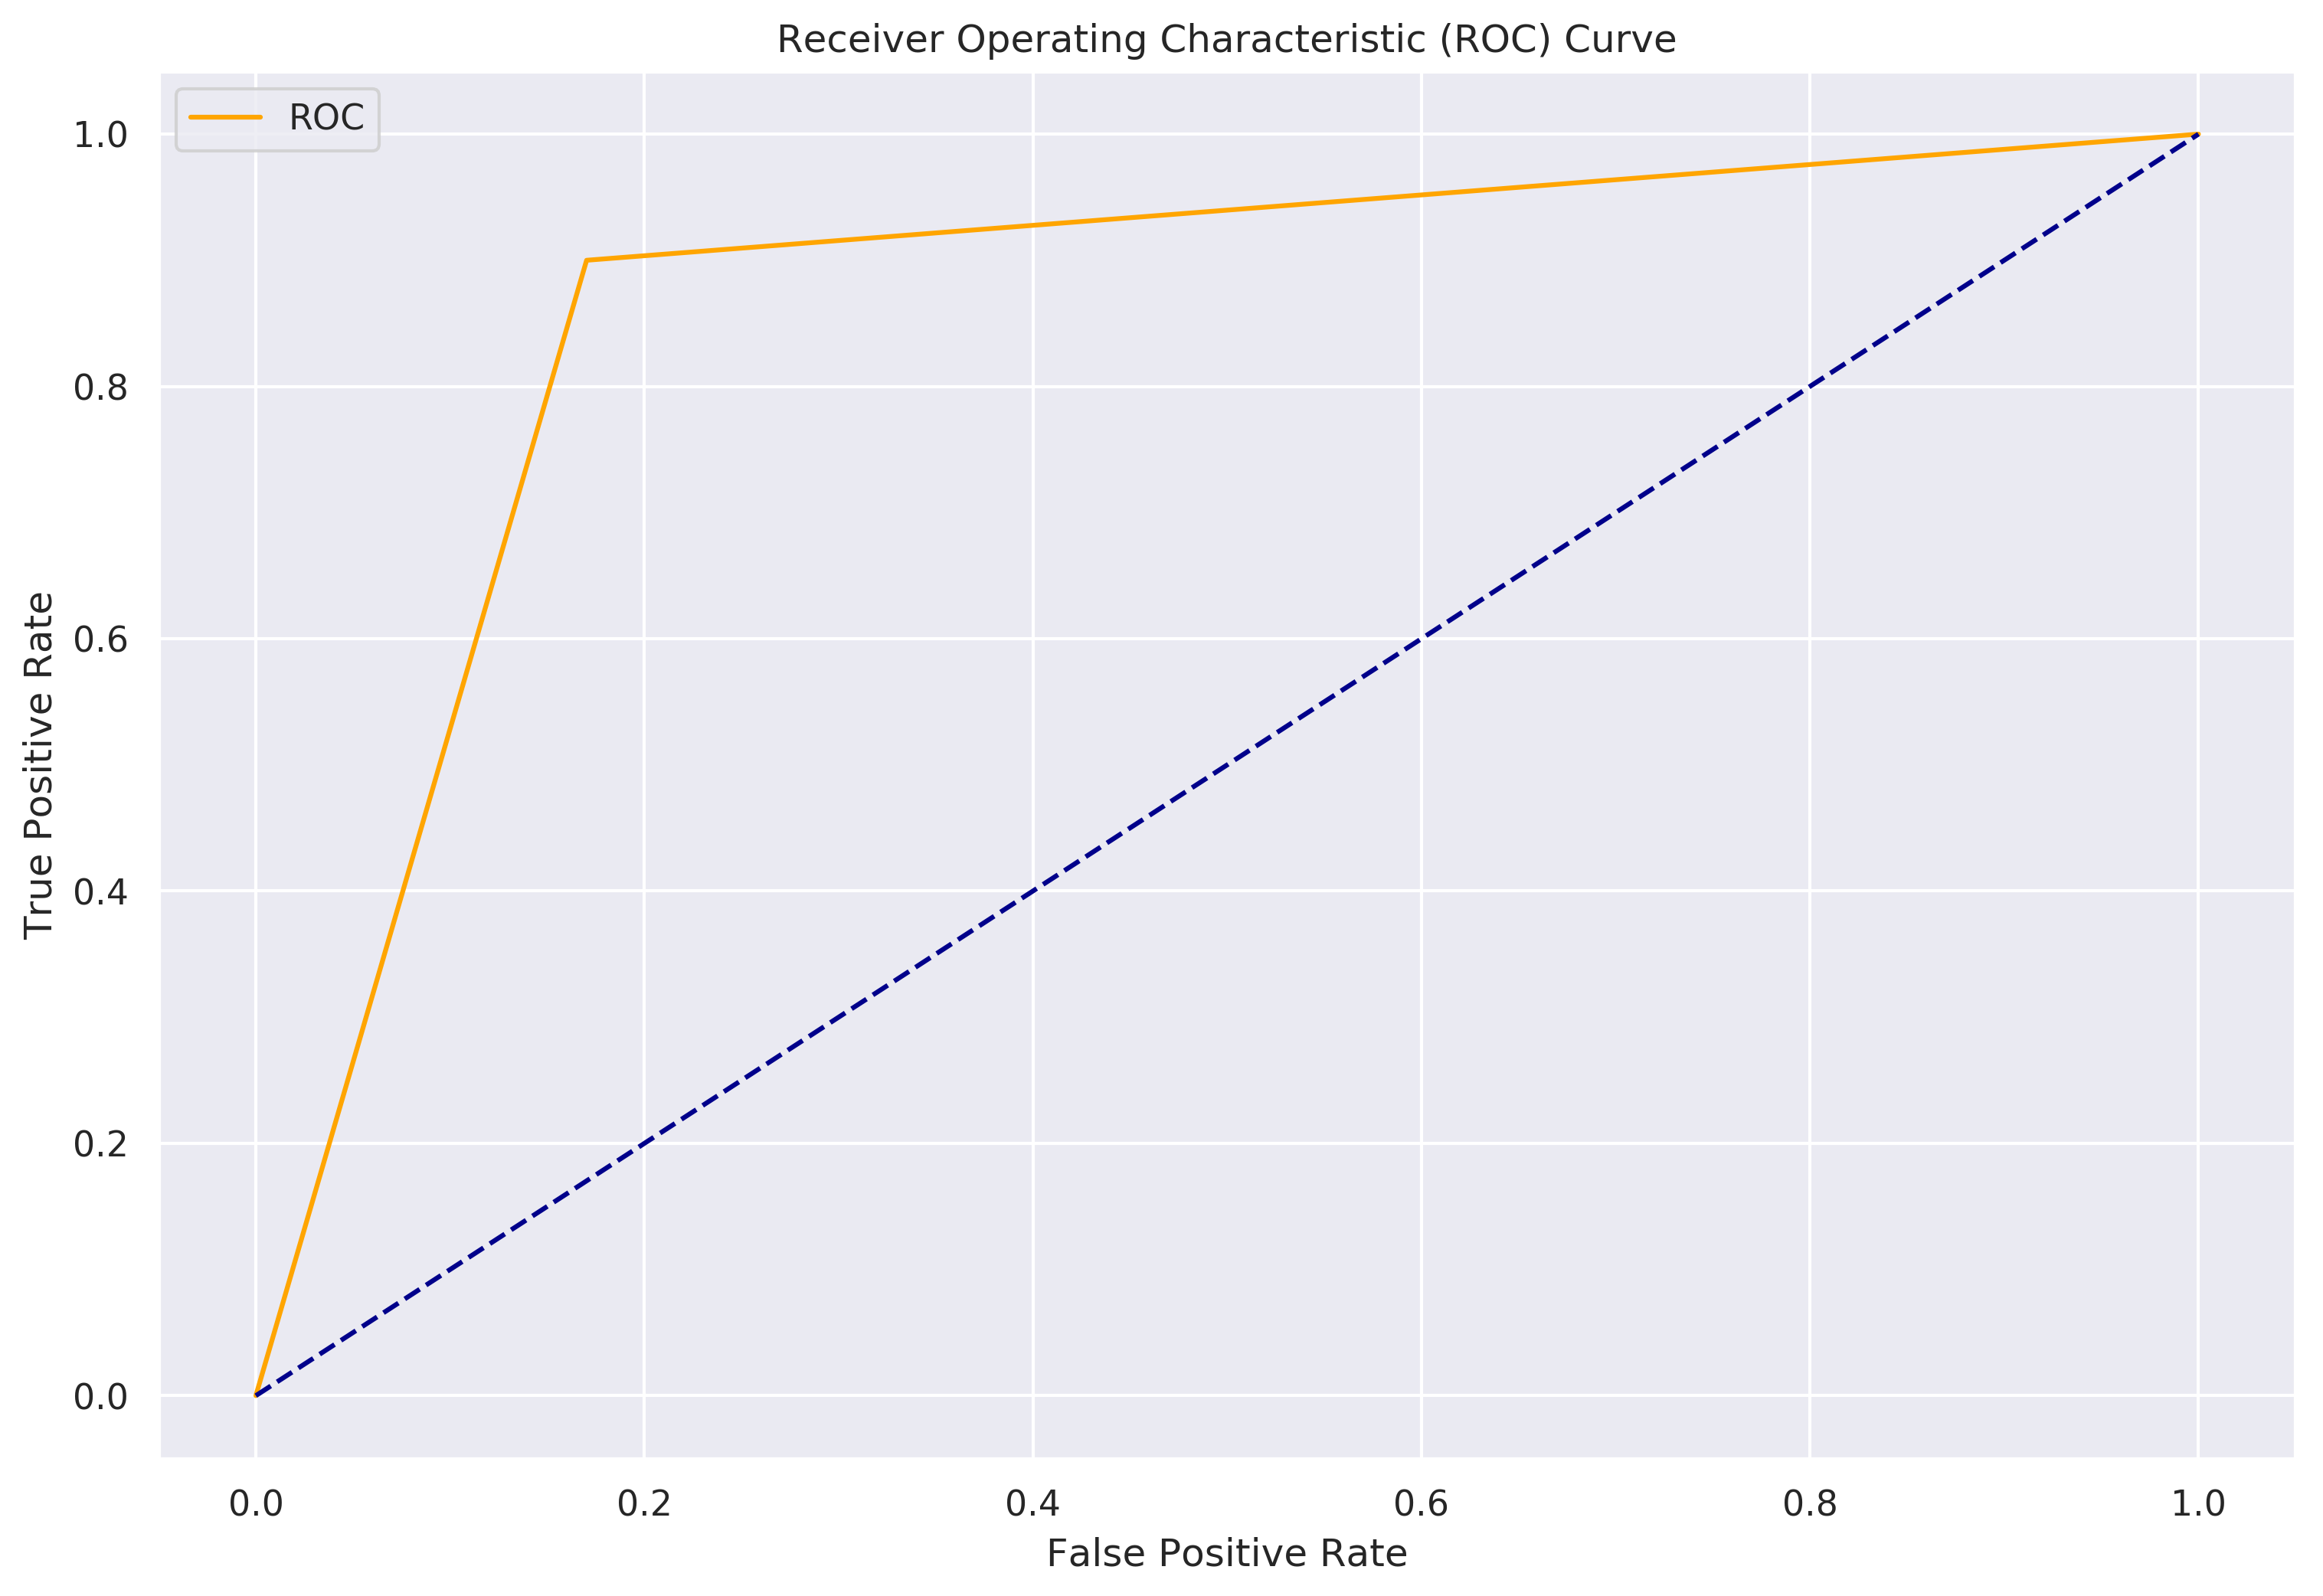

[False False False ... False False False]
True Neg: 59169, False pos: 0, False neg: 90, True pos: 0
AUC: 0.50


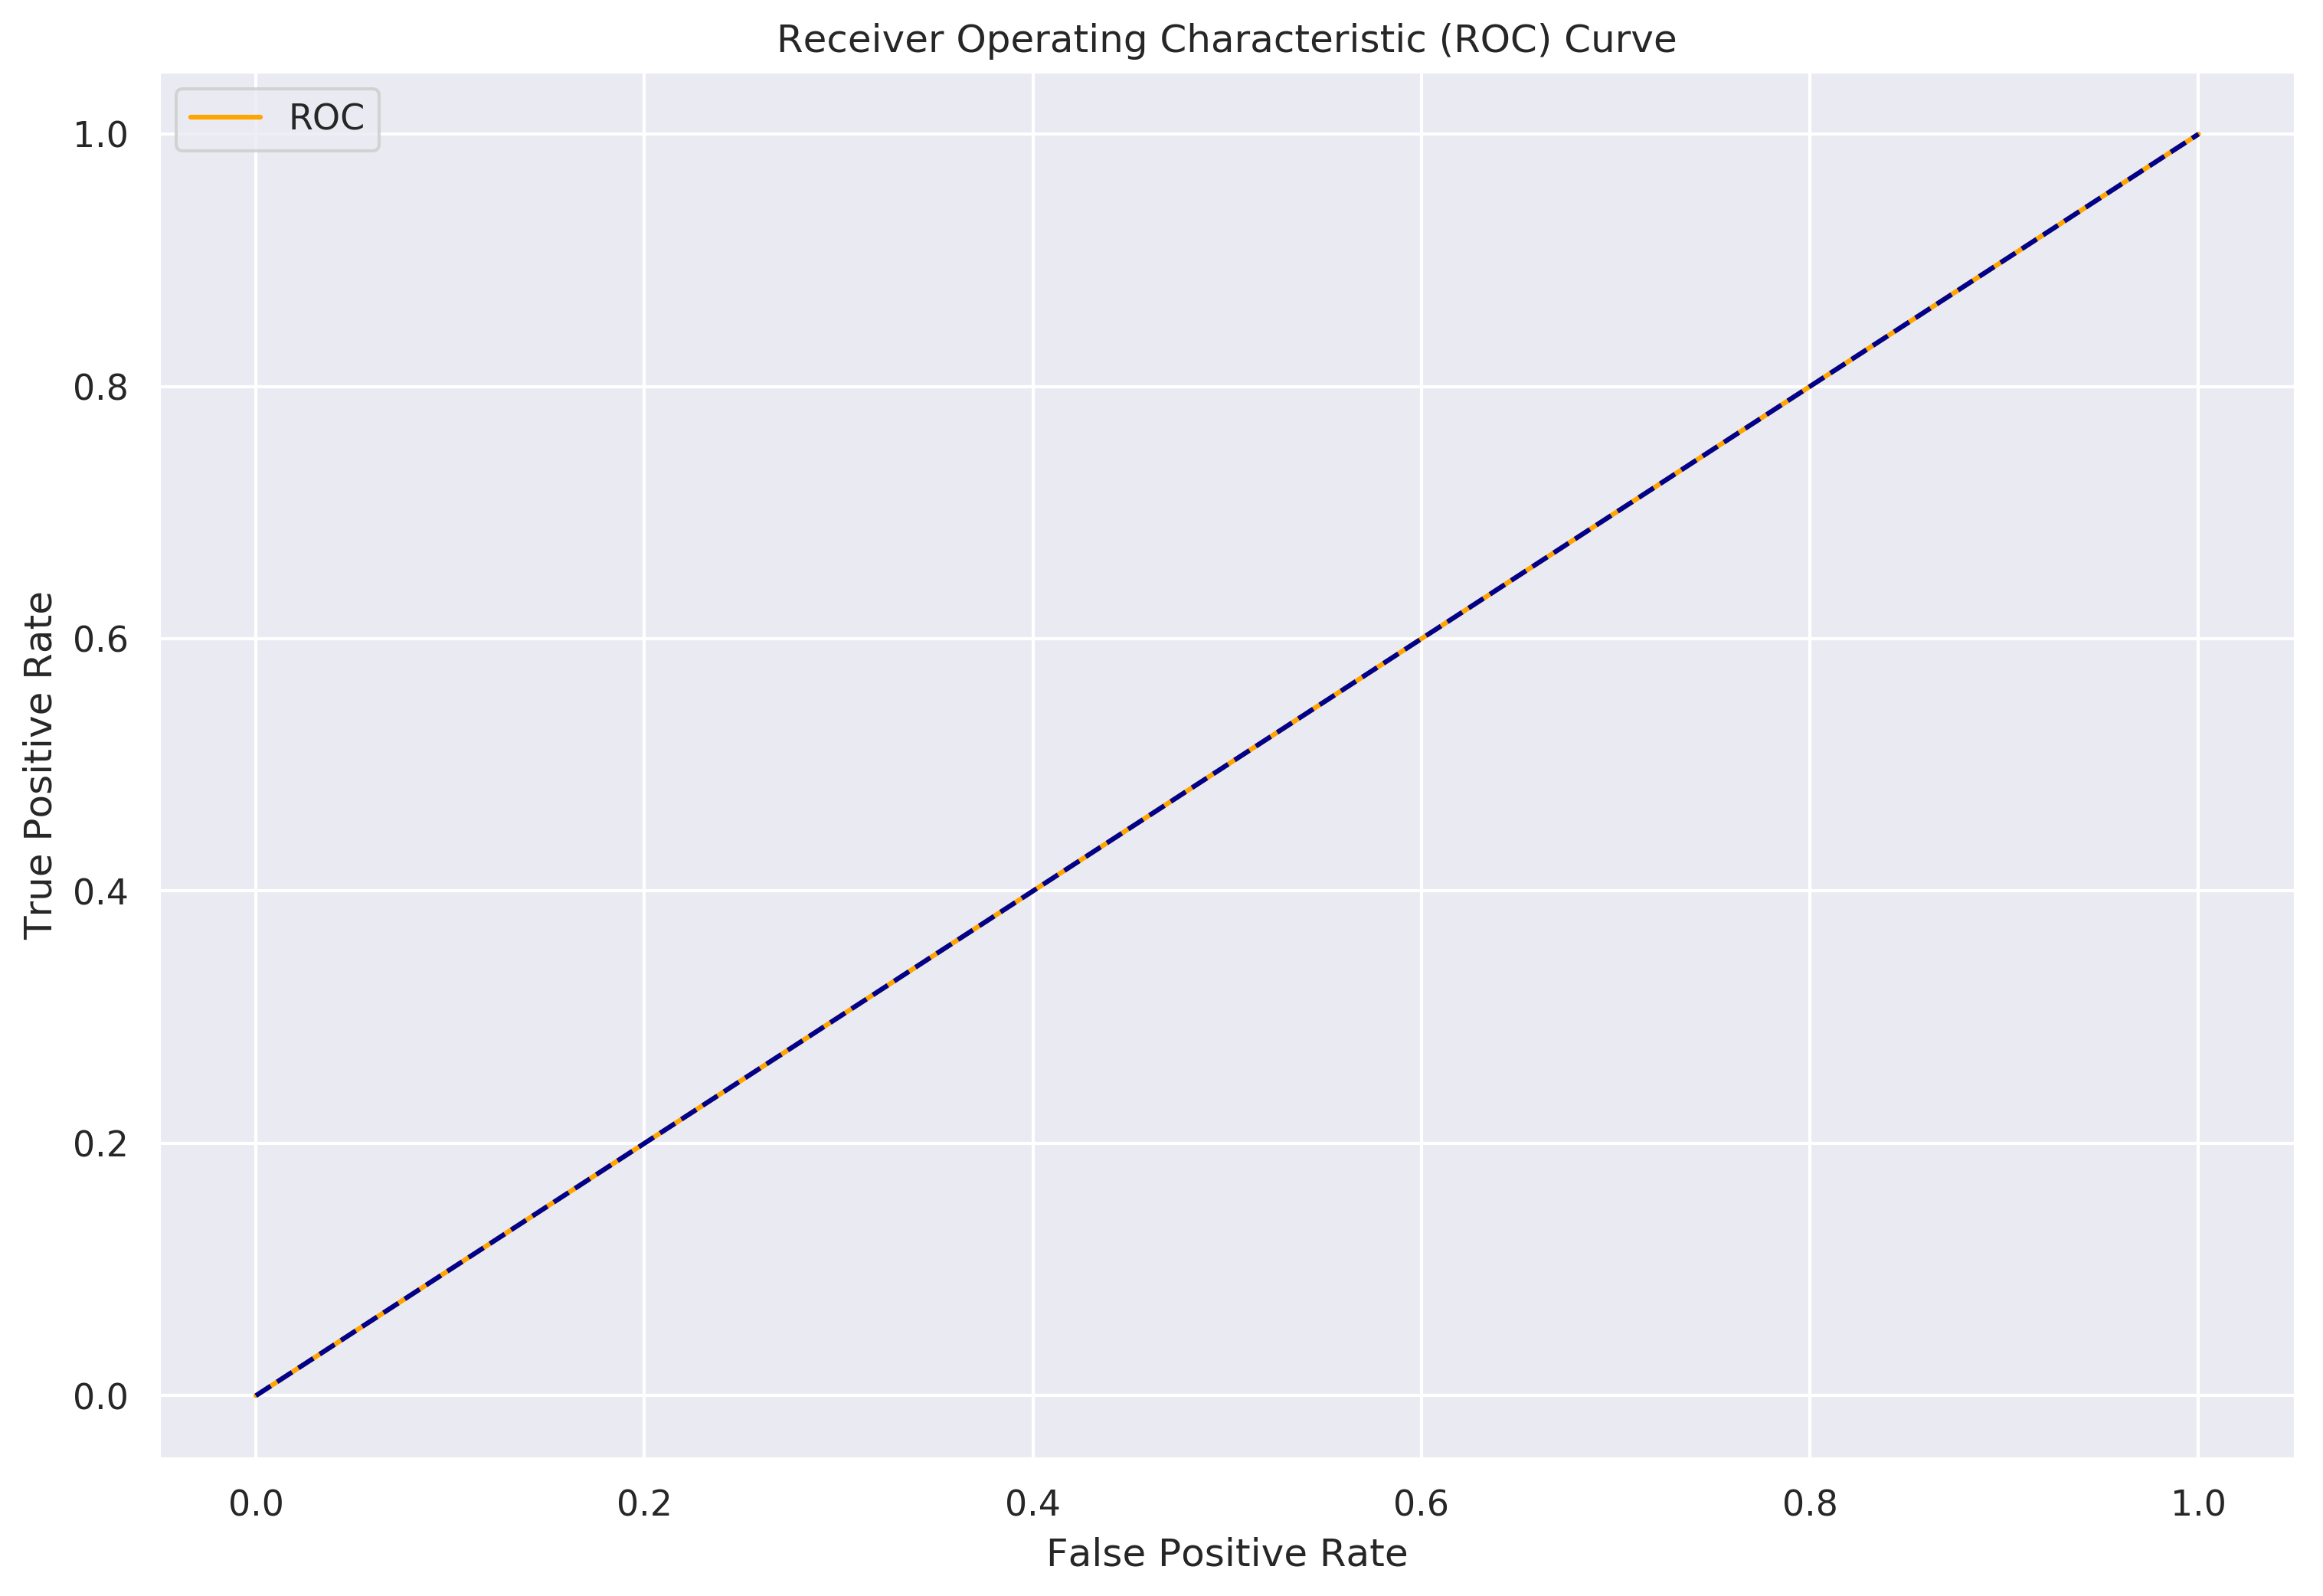

In [385]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def log_reg(smote, train_features, test_features, train_labels, test_labels):
    # Don't use all features
    check = list(df.columns[10:60])
    check.append('amount_convert')
    
    if smote:
        X_train, y_train = apply_smote(train_features, train_labels)
    else:    
        X_train, y_train = (train_features, train_labels)
    
    # Initialize classifier
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

    # Predict test set
    predictions = clf.predict(test_features)
    print(predictions)

     # Evaluate predictions
    get_metric(test_labels, predictions)
    auc = roc_auc_score(test_labels, predictions)  
    print('AUC: %.2f' % auc)  
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
    plot_roc_curve(fpr, tpr).show()

log_reg(True, train_features, test_features, train_labels, test_labels)
log_reg(False, train_features, test_features, train_labels, test_labels)

[False  True False ... False False  True]
True Neg: 49095, False pos: 10074, False neg: 9, True pos: 81
AUC: 0.86


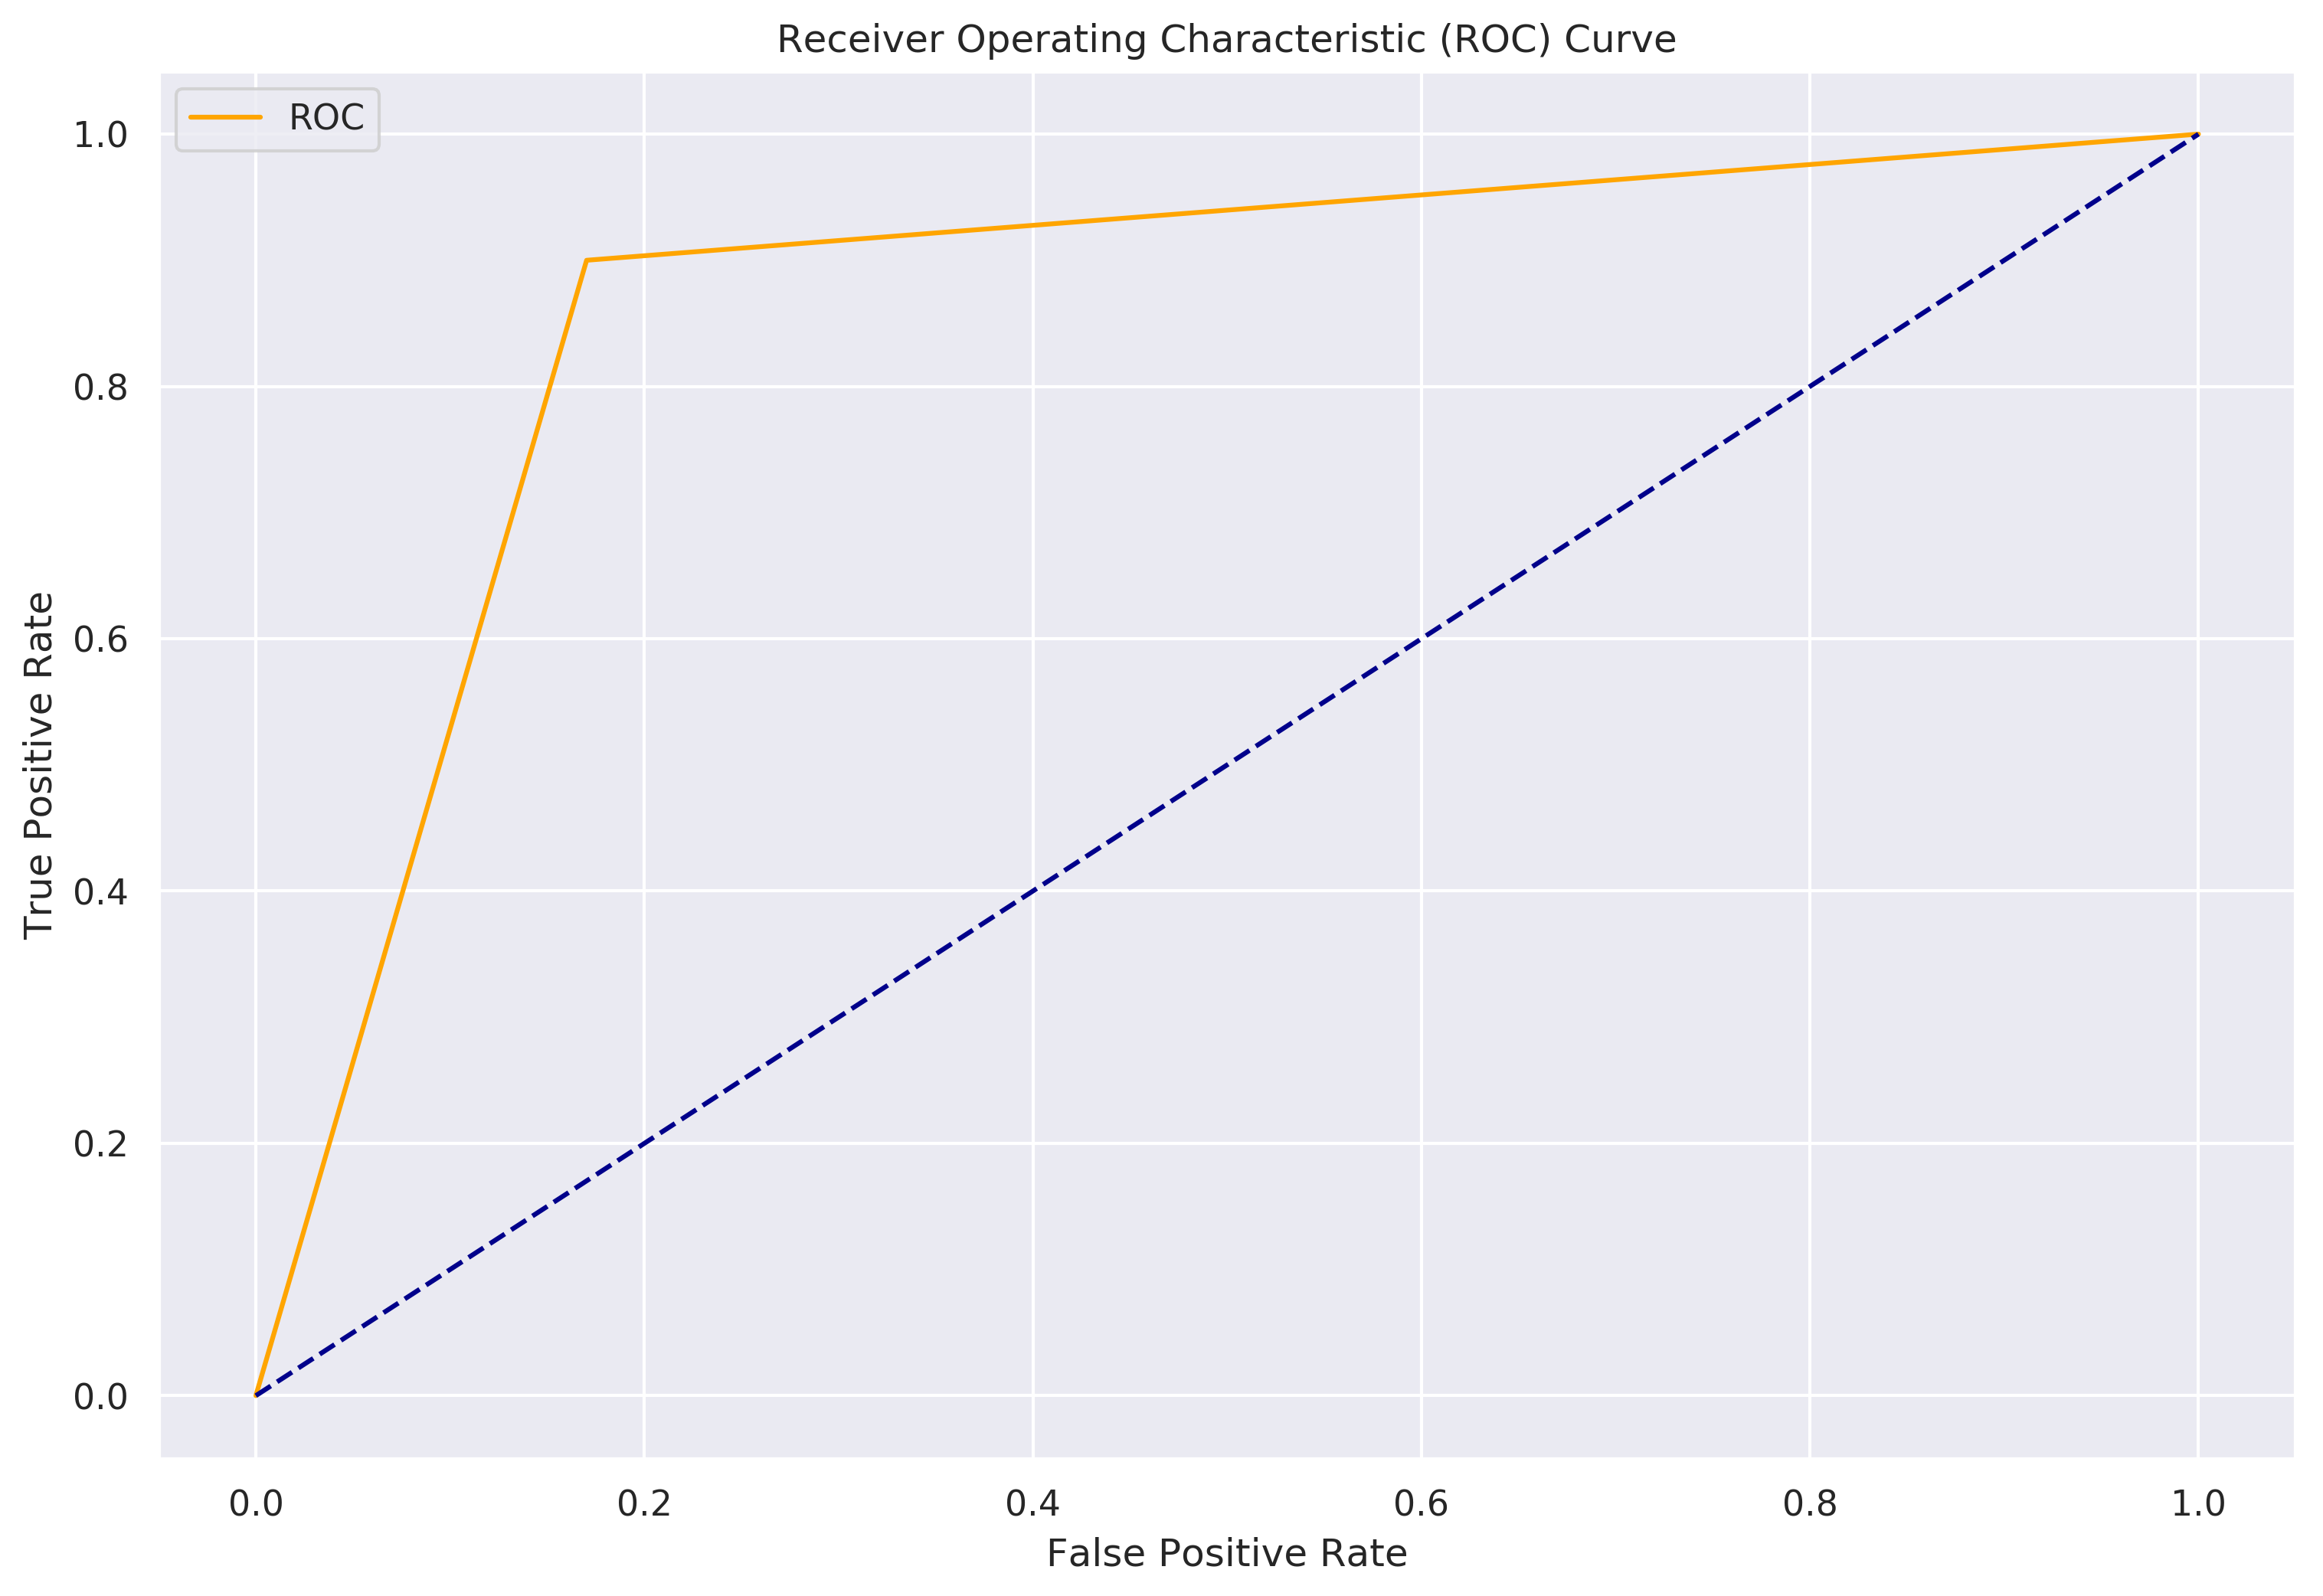

[False False False ... False False False]
True Neg: 59169, False pos: 0, False neg: 90, True pos: 0
AUC: 0.50


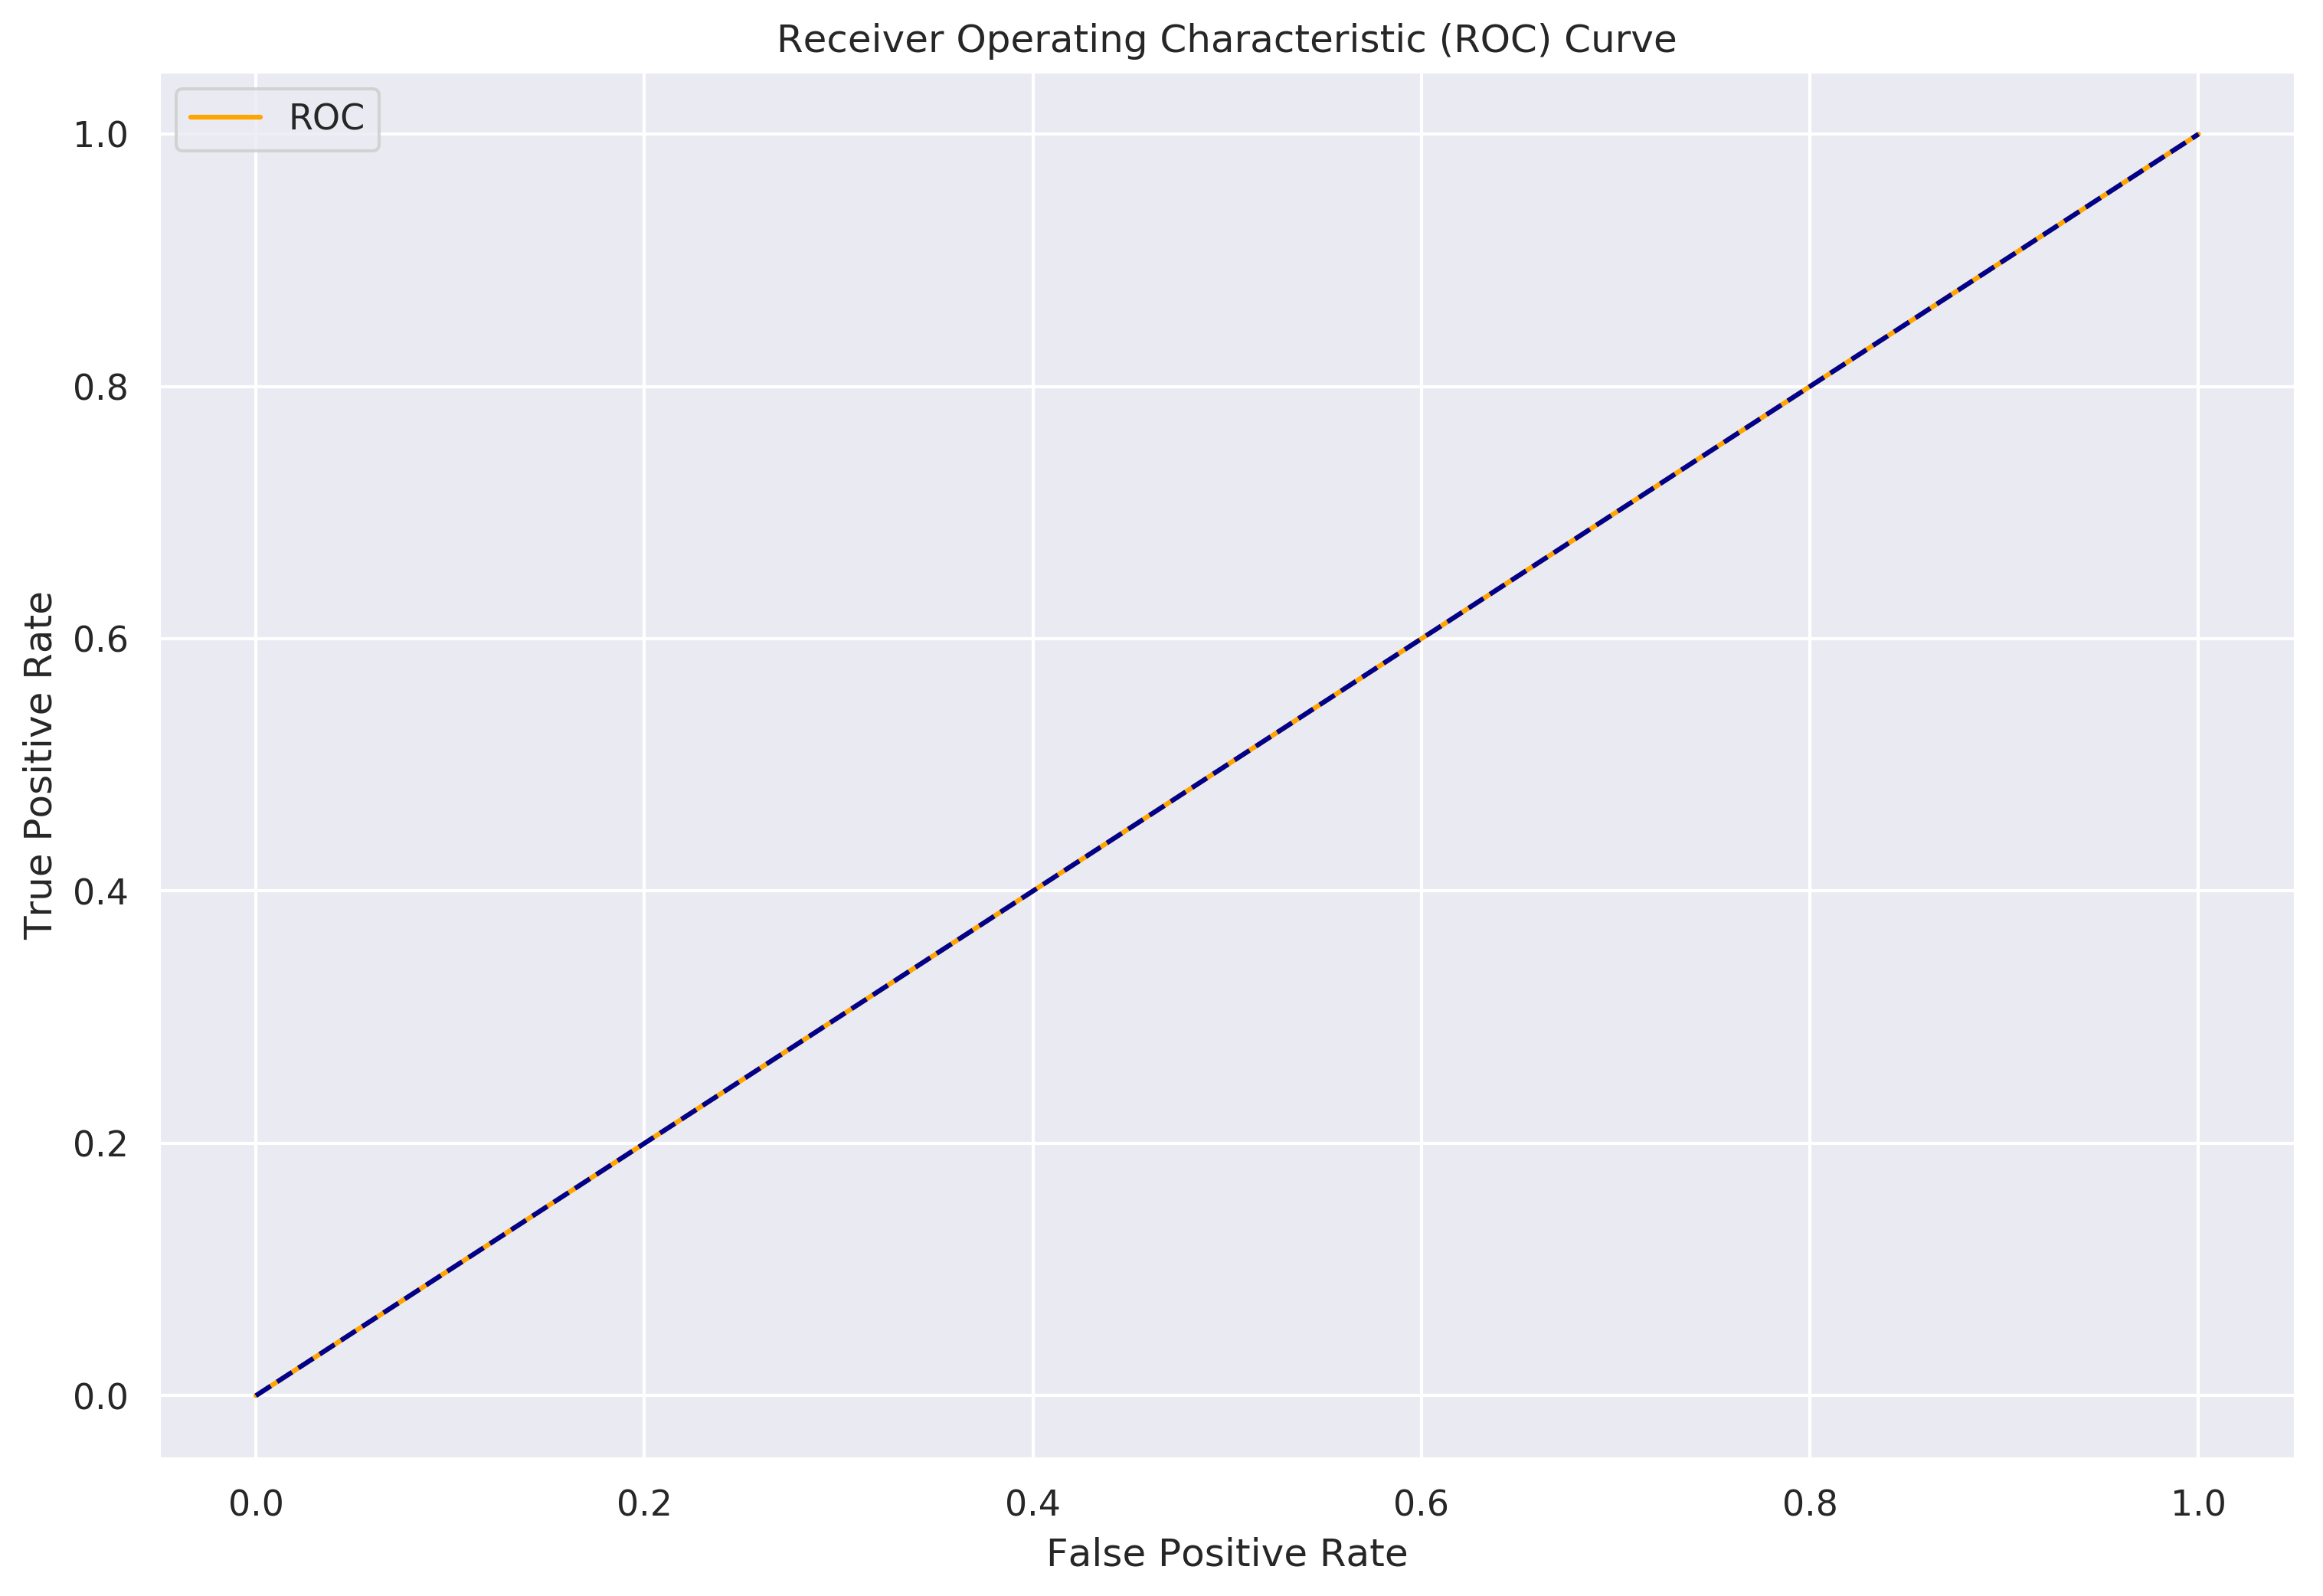

In [386]:
#Logistic Regression with SMOTE
log_reg(True, train_features, test_features, train_labels, test_labels)

# Logistic Regression without SMOTE
log_reg(False, train_features, test_features, train_labels, test_labels)

## 10-fold cross-validation. 

In [389]:
# Random forest cross validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 10)
X_train, y_train, train_features, test_features, train_labels, test_labels = split_and_smote(
    ['amount_convert'])
cross_scores = cross_val_score(rf, X_train, y_train, cv=TimeSeriesSplit(n_splits=10), scoring='recall')
cross_scores.mean()

0.418342299847299

## Combining the 2 with a VotingClassifier

[0.69811321 0.8        0.82978723 0.88636364 0.96436204 0.99993803
 1.         0.99996902 1.         1.        ]
ensemble mean: 0.9178533166087686
True Neg: 59169, False pos: 0, False neg: 11, True pos: 79
AUC: 0.94


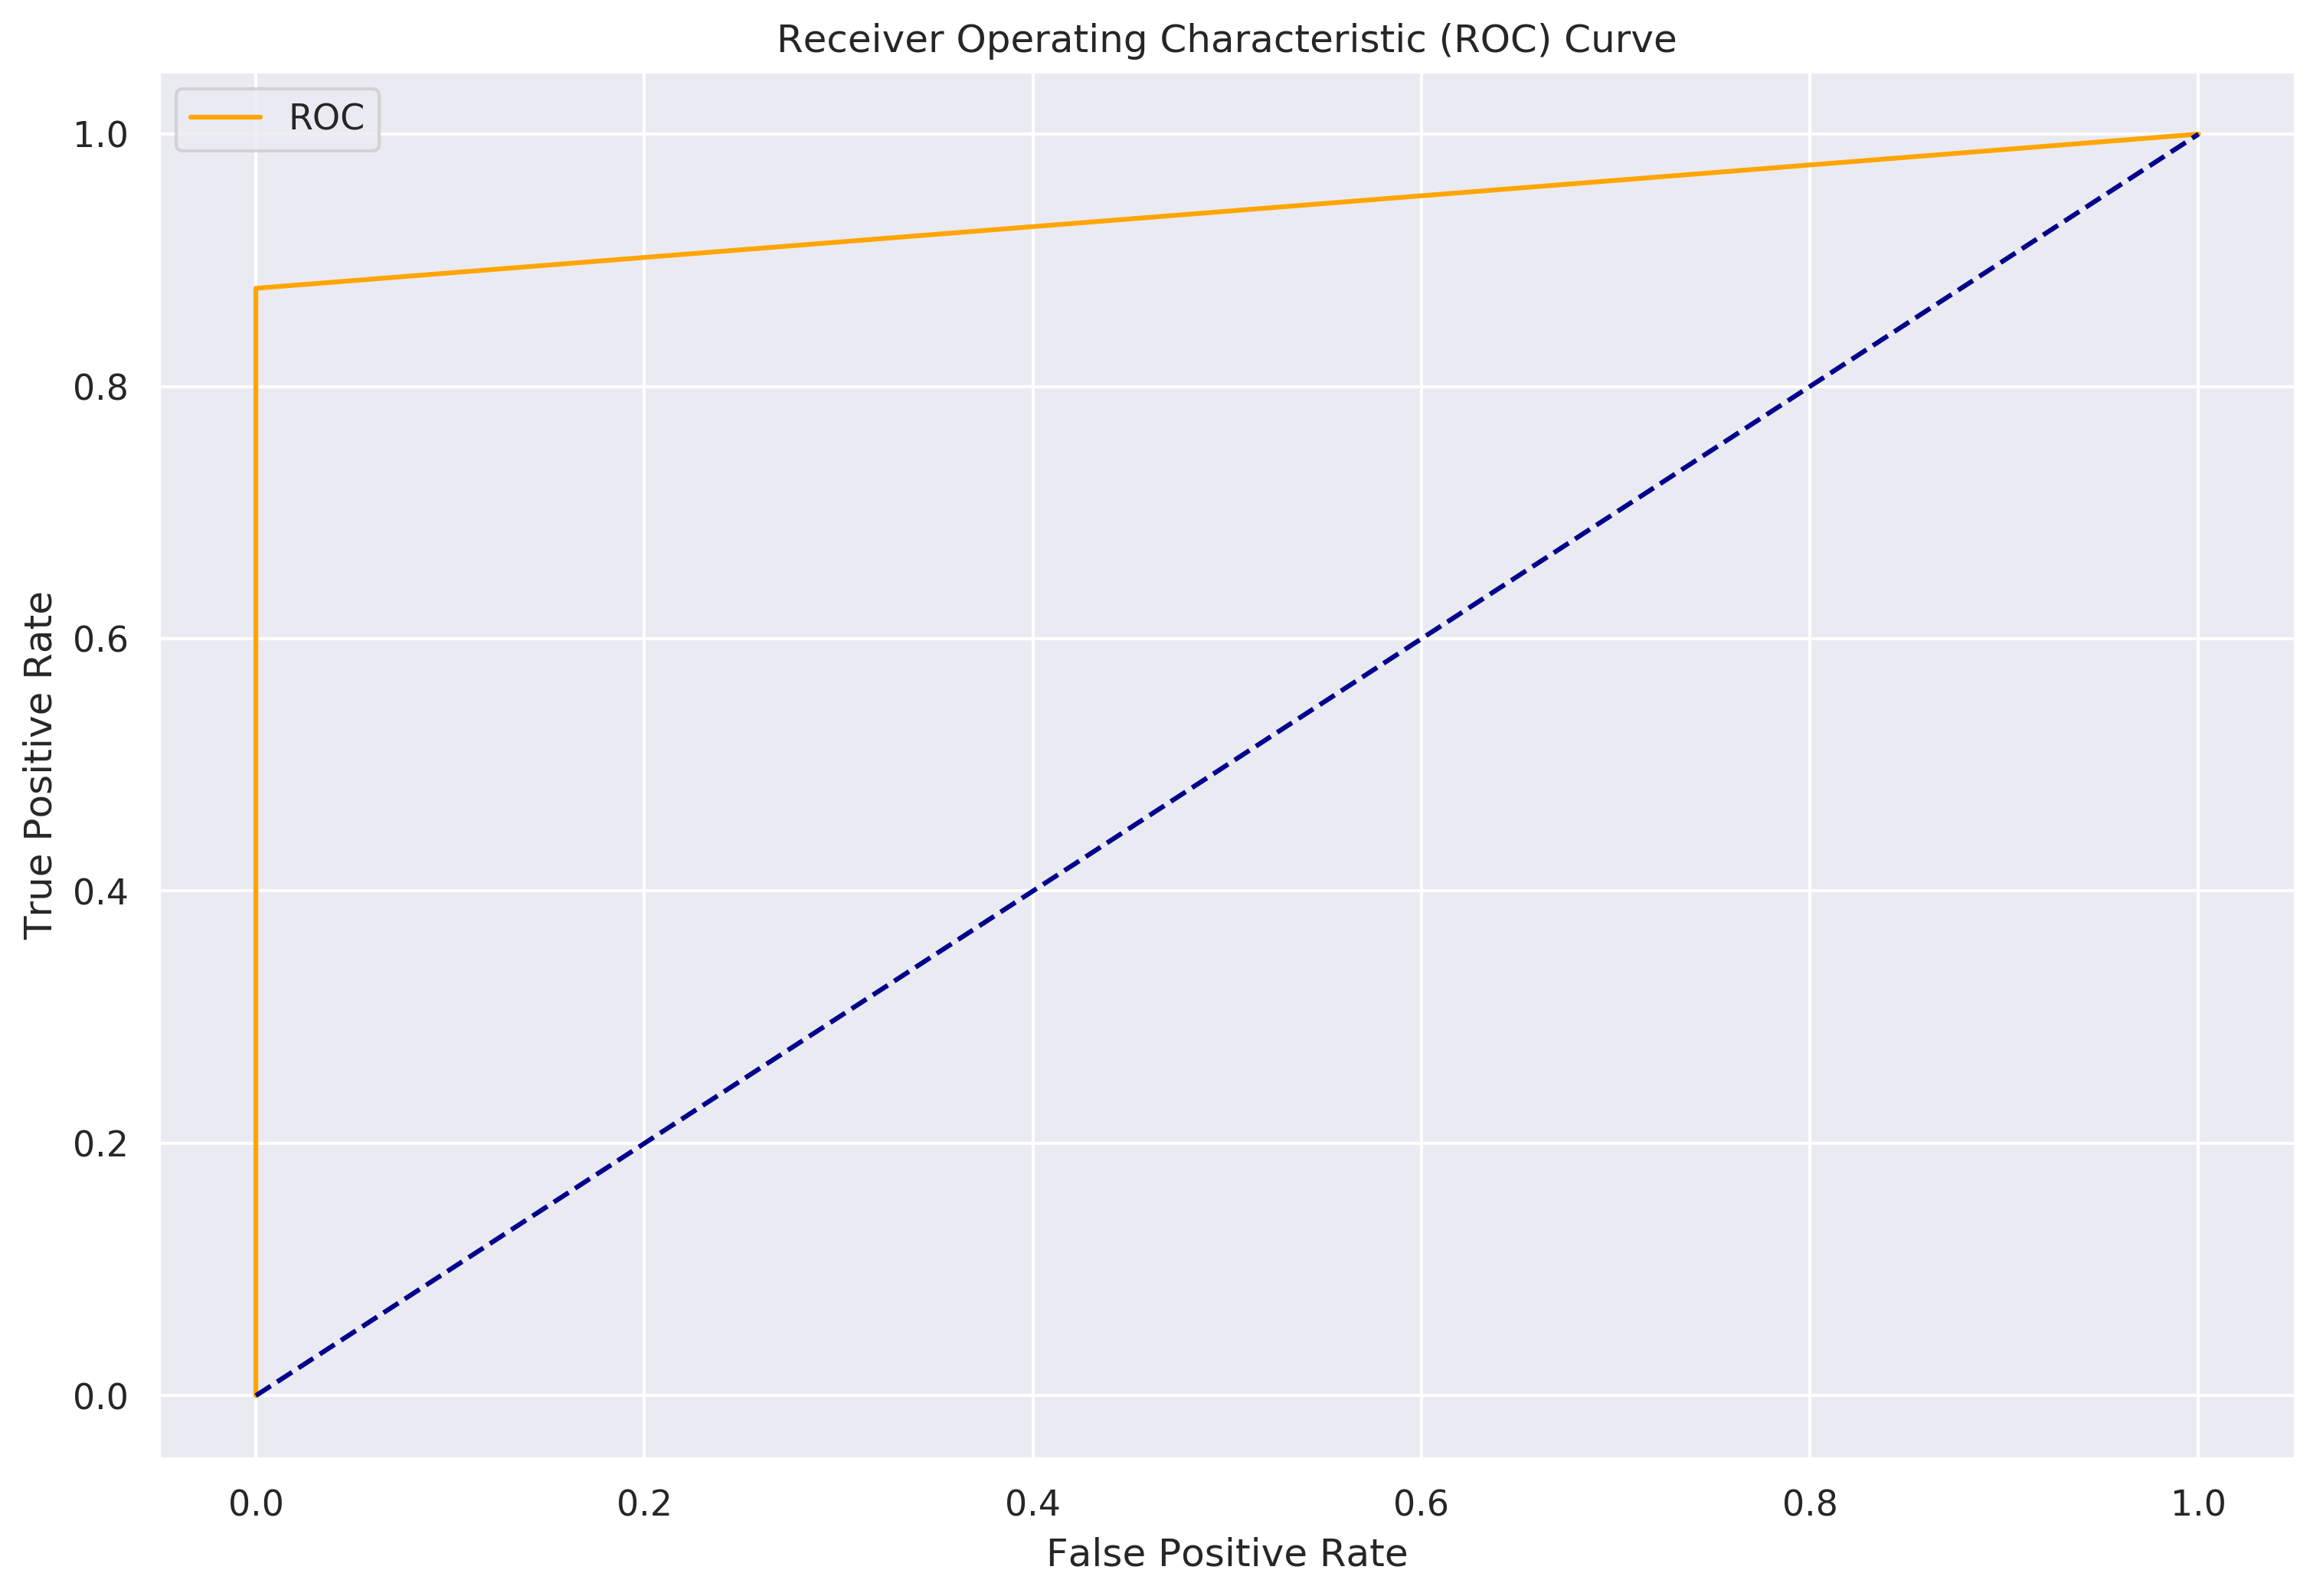

In [393]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# Set up the classifiers
lr = LogisticRegression(solver='lbfgs')
rfc = RandomForestClassifier(n_estimators=10)
mlp = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(15,), random_state=0)

X_train, y_train, train_features, test_features, train_labels, test_labels = split_and_smote([])

# Add wanted classifiers to an ensemble
voting_ensemble = VotingClassifier(estimators=[('rf', rfc), ('lr', rfc)])

# Calculate the score of the classifier using cross validation and splitting in 10 series
ensemble_score = cross_val_score(voting_ensemble, X_train, y_train, cv=TimeSeriesSplit(n_splits=10), scoring='recall')
print(ensemble_score)
print(f'ensemble mean: {np.mean(ensemble_score)}')

voting_ensemble.fit(X_train, y_train)
predictions = voting_ensemble.predict(test_features)

# Making a ROC curve for the combined classifier
get_metric(test_labels, predictions)
auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
plot_roc_curve(fpr, tpr).show()